In [1]:
%matplotlib inline
from ROOT import TFile, TTree

import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
import pandas as pd
import re
from scipy import stats

from root_numpy import root2array

In [2]:
filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/CCInclusive/mac/THESIS_OUTPUT/'

!ls -ltra $filedir | tail -n 10

total 20128
-rw-r--r--   1 davidkaleko  staff      214 Feb 15 10:57 run_commands.txt
-rw-r--r--   1 davidkaleko  staff  8350787 Feb 15 11:05 ana_out_trkpandoraNuPMA_vtxpmtrack_mcc71ext2bnb3_1_THESIS.root
-rw-r--r--   1 davidkaleko  staff   259743 Feb 15 11:07 ana_out_trkpandoraNuPMA_vtxpmtrack_mcc71ext2bnb3_2_THESIS.root
drwxr-xr-x   6 davidkaleko  staff      204 Feb 15 11:07 .
-rw-r--r--   1 davidkaleko  staff  1686279 Feb 15 11:07 ana_out_trkpandoraNuPMA_vtxpmtrack_mcc71ext2bnb3_3_THESIS.root
drwxr-xr-x  93 davidkaleko  staff     3162 Feb 17 12:53 ..


In [3]:
track_producer = 'pandoraNuPMA'
vtx_producer = 'pmtrack'

In [4]:
#To create these files do:
# python $LARLITE_USERDEVDIR/KalekoAna/CCInclusive/mac/run_XiaoEventAna_customProducers.py \
# pandoraNuPMA pmtrack pandoraNuPMAcalo 1 THESIS_OUTPUT/ \
# /Users/davidkaleko/Data/larlite/082416_selection_output/saved_evts_trkpandoraNuPMA_vtxpmtrack_mcc71ext2bnb3_1.root
# (replacing 1 with 2 and 3 for the other samples)

mcnu = 'ana_out_trk%s_vtx%s_mcc71ext2bnb3_1_THESIS.root'%(track_producer,vtx_producer)
datanu =  'ana_out_trk%s_vtx%s_mcc71ext2bnb3_3_THESIS.root'%(track_producer,vtx_producer) 
databkg = 'ana_out_trk%s_vtx%s_mcc71ext2bnb3_2_THESIS.root'% (track_producer,vtx_producer) 


files = { 'mcnu' : filedir + mcnu, 
         'datanu' : filedir + datanu, 
         'databkg' : filedir + databkg }

mycuts = [#'longest_trk_len_infidvol > 20.',# 'longest_trk_len_infidvol > 50.', 'longest_trk_len_infidvol > 00.', 
    'longest_trk_len_infidvol > 15.',
    #'longest_trk_len_infidvol > 250.',
          'nu_E_estimate > 2.5',
    #'longest_track_end_y_infidvol < 85. and longest_track_end_y_infidvol > -85.',
    #'longest_trk_cosy > -0.5',
    #'n_associated_tracks > 2',
    #'longest_trk_len > 300.',
    #'longest_trk_cosy < 0.25 and longest_trk_cosy > -0.25',
    #'longest_trk_cosy < 0.5',
    #'longest_trk_theta < 1.5',
    #'(longest_trk_len > 100. and longest_trk_contained and not MCS_linecut)',
    #'(longest_trk_len > 100. and not longest_trk_contained)',
    #'not longest_trk_contained',
    #'not MCS_linecut',
          #'second_longest_trk_len > 25.',# 'second_longest_trk_len > 16.',
          'longest_tracks_dotprod_trkendpoints > -0.995']
        #'(longest_track_end_z_infidvol < 600 or longest_track_end_z_infidvol > 800)']
        #'(reco_nu_z < 600 or reco_nu_z > 800)']
           #'reco_nu_z < 675.']
         #'longest_track_end_x < 250. and longest_track_end_x > 10.',
        #'longest_track_end_y_infidvol < 80. and longest_track_end_y_infidvol > -80.']
          #'not (longest_track_end_z > 650. and longest_track_end_z < 750.)']

        

In [5]:
df_dict = {}

for sample, filepath in files.iteritems():
    df_dict[sample] = pd.DataFrame( root2array ( filepath, 'tree' ) )
    
    #temp adding column
    df_dict[sample]['lephaddiff'] = df_dict[sample]['E_lepton'] - df_dict[sample]['E_hadrons']
    df_dict[sample]['lephadratio'] = df_dict[sample]['E_lepton'] / df_dict[sample]['E_hadrons']
    df_dict[sample]['longest_tracks_dotprod_trkendpoints_abs'] = \
    np.abs(df_dict[sample]['longest_tracks_dotprod_trkendpoints'])
    df_dict[sample]['longest_trk_costheta'] = np.cos(df_dict[sample]['longest_trk_theta'])
    df_dict[sample]['longest_trk_MCS_mom_spline_ratio'] = \
        df_dict[sample]['longest_trk_MCS_mom'] / (df_dict[sample]['longest_trk_spline_mom']/1000.)
        
    #df_dict[sample]['lengthoverLength'] = df_dict[sample]['longest_trk_len_infidvol'] / \
    #    df_dict[sample]['longest_trk_Length_infidvol']
    #df_dict[sample]['lengthoverLength_smeared'] = df_dict[sample]['longest_trk_len_infidvol_smeared'] / \
    #    df_dict[sample]['longest_trk_Length_infidvol_smeared']
    df_dict[sample]['contained_wellrecod'] = df_dict[sample]['longest_trk_contained'] == True & \
        (df_dict[sample]['longest_trk_MCS_mom'] > 0) & \
        ((df_dict[sample]['longest_trk_MCS_mom'] / df_dict[sample]['longest_trk_spline_mom']) < 1.5)
    df_dict[sample]['MCS_ratio'] = df_dict[sample]['E_MCS'] / \
        (df_dict[sample]['E_MCS'] + df_dict[sample]['E_range'])
    df_dict[sample]['MCS_linecut'] = df_dict[sample]['longest_trk_MCS_mom'] > \
        (0.25 + 1.25*(df_dict[sample]['longest_trk_spline_mom']/1000.))

df_dict['mcnu']['artificial_E'] = df_dict['mcnu']['nu_E_estimate'] * 0.85
df_dict['datanu']['artificial_E'] = df_dict['datanu']['nu_E_estimate'] 
df_dict['databkg']['artificial_E'] = df_dict['databkg']['nu_E_estimate'] 

df_dict['mcnu']['artificial_E_2'] = df_dict['mcnu']['E_MCS']*0.9546 + df_dict['mcnu']['E_range']
df_dict['datanu']['artificial_E_2'] = df_dict['datanu']['E_MCS'] + df_dict['datanu']['E_range'] 
df_dict['databkg']['artificial_E_2'] = df_dict['databkg']['E_MCS'] + df_dict['databkg']['E_range'] 

df_dict['mcnu']['artificial_E_3'] = df_dict['mcnu']['E_MCS']*0.90 + df_dict['mcnu']['E_range']
df_dict['datanu']['artificial_E_3'] = df_dict['datanu']['E_MCS'] + df_dict['datanu']['E_range'] 
df_dict['databkg']['artificial_E_3'] = df_dict['databkg']['E_MCS'] + df_dict['databkg']['E_range'] 


#df_dict['mcnu']['longest_trk_MCS_mom_reweighted_MConly'] = df_dict['mcnu']['longest_trk_MCS_mom_reweighted']
#df_dict['datanu']['longest_trk_MCS_mom_reweighted_MConly'] = df_dict['datanu']['longest_trk_MCS_mom']
#df_dict['databkg']['longest_trk_MCS_mom_reweighted_MConly'] = df_dict['databkg']['longest_trk_MCS_mom']

df_dict['mcnu']['longest_trk_MCS_mom_scaled_MConly'] = df_dict['mcnu']['longest_trk_MCS_mom'] * 0.9546
df_dict['datanu']['longest_trk_MCS_mom_scaled_MConly'] = df_dict['datanu']['longest_trk_MCS_mom']
df_dict['databkg']['longest_trk_MCS_mom_scaled_MConly'] = df_dict['databkg']['longest_trk_MCS_mom']

df_dict['mcnu']['longest_trk_MCS_mom_arbscaled_MConly'] = df_dict['mcnu']['longest_trk_MCS_mom'] * 0.85
df_dict['datanu']['longest_trk_MCS_mom_arbscaled_MConly'] = df_dict['datanu']['longest_trk_MCS_mom']
df_dict['databkg']['longest_trk_MCS_mom_arbscaled_MConly'] = df_dict['databkg']['longest_trk_MCS_mom']


if 'SPACECHARGE' in mcnu:
    #Need to change 'correct ID' definition to be looser when spacecharge effect is added
    df_dict['mcnu']['correct_ID'] = df_dict['mcnu']['dist_reco_true_vtx'] < 10

In [6]:
print filedir

/Users/davidkaleko/larlite/UserDev/KalekoAna/CCInclusive/mac/THESIS_OUTPUT/


In [7]:
n_evts_analyzed = { 'mcnu': 180000, 'databkg' : 380897, 'datanu' : 547617 }
#databkg has 372465 for latest selection since some jobs failed!
#older selections have 380897

if 'SPACECHARGE' in mcnu:
    print "CHANGING MCNU EVENTS SINCE THIS IS SPACECHARGE (SMALLER SAMPLE)!"
    n_evts_analyzed['mcnu'] = 94800
if 'MEC' in mcnu:
    print "CHANGING MCNU EVENTS SINCE THIS IS MEC SAMPLE!"
    n_evts_analyzed['mcnu'] = 206400
if '082416' in filedir:
    print "WARNING! 082316 in file dir, so changing databkg n_evts_analyzed due to failed jobs!"
    n_evts_analyzed['databkg'] = 372465
if '090816' in filedir or '090916' in filedir or '091416' in filedir or '091516' in filedir:
    print "WARNING! 090816 (or 090916) in file dir, so changing databkg n_evts_analyzed due to failed jobs!"
    n_evts_analyzed['databkg'] = 372465
if '090616' in filedir:# or 'CCInclusive' in filedir:
    print "WARNING! 090616 in file dir, so changing databkg n_evts_analyzed due to failed jobs!"
    n_evts_analyzed['databkg'] = 372465
if '100316' in filedir: # or 'CCInclusive' in filedir:
    print "WARNING! 100316 in file dir, so changing n_evts_analyzed slightly due to failed jobs!"
    n_evts_analyzed['mcnu'] = n_evts_analyzed['mcnu'] * (187760./180000)
    n_evts_analyzed['databkg'] = n_evts_analyzed['databkg'] * (277132./380897)
    n_evts_analyzed['datanu'] = n_evts_analyzed['datanu'] * (543502./547617)

In [8]:
pot_per_sample = { 'mcnu' : (1.2105e15) * n_evts_analyzed['mcnu'],
                   'datanu' : 4.88e19 }
pot_per_sample['databkg'] = pot_per_sample['datanu'] * 0.844 * \
                  float(n_evts_analyzed['datanu'])/n_evts_analyzed['databkg']
#pot_per_sample['mcbkg'] = pot_per_sample['databkg'] * (1./0.336) * \
#                  float(n_evts_analyzed['mcbkg'])/n_evts_analyzed['databkg'] 

if 'MEC' in mcnu:
    print "CHANGING MCNU POT PER EVENT SINCE THIS IS MEC SAMPLE!"
    pot_per_sample['mcnu'] = (1.0385e15) * n_evts_analyzed['mcnu']
if 'SPACECHARGE' in mcnu:
    print "CHANGING MCNU POT PER EVENT SINCE THIS IS SPACECHARGE SAMPLE!"
    pot_per_sample['mcnu'] = (1.234e15) * n_evts_analyzed['mcnu']

In [9]:
def computeChiSqPval(beamonhist,beamoffhist,mchist):
    
    #beamonhist, beamoffhist are vectors of the histogram bin contents
    #mchist is vector of the summed MC histograms (cosmic+pion+kaon whatever)
    
    #it is just, Δχ2 = (number of events signal in Energy bins in a 1D matrix) 
    #(2D Martix - (statistical uncertainty)^2 in a the diagonal of the matrix)^-1 
    #(number of events signal in Energy bins in a 1D matrix)^Transpose

    nbins = len(beamonhist)
    
    #error matrix of stat uncertainty, diagonals only
    #diagonal is (beamon-beamoff stat error)^2 + (mchist stat error)^2 [no sqrt]
    #mchist stat error is sqrt(N_mc)
    #beamon-beamoff stat error is sqrt( sqrt(N_beamon)^2 + sqrt(N_beamoff)^2 )
    #  = sqrt( N_beamon + N_beamoff )
    emtx   = np.zeros((nbins,nbins))
    datavec = np.array(np.array(beamonhist)-np.array(beamoffhist)).reshape((1,nbins))
    mcvec  = np.array(mchist)
    
    for x in xrange(nbins):
        emtx[x][x] = beamonhist[x]+beamoffhist[x]+mchist[x]
        if not (beamonhist[x]+beamoffhist[x]+mchist[x]):
            emtx[x][x] = 1
    
    emtxinv = np.linalg.inv(emtx)
    
    chisq = float((datavec-mcvec).dot(emtxinv).dot((datavec-mcvec).T))
    #print "Sqrt of that (==sigma?) is ",np.sqrt(chisq)
    pval = stats.chi2.cdf(chisq,nbins)
    #return np.sqrt(chisq)
    print "Chisq is %f, DOF is %d, pval is %f"%(chisq,nbins,pval)
    return pval

def computeSimpleChiSqPval(beamonhist,beamoffhist,mchist):
    nbins = len(beamonhist)
    datavec = np.array(np.array(beamonhist)-np.array(beamoffhist)).reshape((1,nbins))
    mcvec  = np.array(mchist)
    chisq = np.sum(np.square(datavec-mcvec)/mcvec)
    #return np.sqrt( chisq )
    return stats.chi2.cdf(chisq,nbins)

In [10]:
def plotVariableComparison(myvar, mybins, myquery, mytitle, myshapeonly = False, myylims = None,\
                           myxlabel = 'test', myylabel = 'test', mylogy = None, draw_data = True, sideband_only=False):

    temp_cosm_scale_weight = 1
    
    fig = plt.figure(figsize=(10,8)) #6
    gs=gridspec.GridSpec(2,1,height_ratios=[3,1])
    #f, axarr = plt.subplots(2, sharex=True,figsize=(10,12))
    
    
    if draw_data:
        axarr = [fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0])]
    else:
        axarr = [fig.add_subplot(gs[0,0])]
        
    fig.subplots_adjust(hspace=.1)
    
    poop = axarr[0].grid(True)
    if draw_data:
        poop = axarr[1].grid(True)
    
    if myshapeonly:
        mytitle = mytitle + ' (SHAPE ONLY)'
    axarr[0].set_title(mytitle,fontsize=16)
    axarr[0].set_ylabel('Events: 5e19 POT Normalized',fontsize=16)
    
    mydict = df_dict['mcnu']
    if myquery: mydict = df_dict['mcnu'].query(myquery)
    if sideband_only: mydict = mydict.query('nu_E_estimate < 2.5')
    #myvals = mydict[myvar].values
    myweight = (5.e19) / pot_per_sample['mcnu']
    
    myvals_pion = mydict.query('fndecay > 10 and true_nu_CCNC == 0 and correct_ID == 1')[myvar].values
    myvals_kaon = mydict.query('fndecay <= 10 and true_nu_CCNC == 0 and correct_ID == 1')[myvar].values
    myvals_NC   = mydict.query('true_nu_CCNC == 1 and correct_ID == 1')[myvar].values
    myvals_cosm = mydict.query('correct_ID == 0')[myvar].values
    #integral = float(len(myvals))*myweight
    totalhist = None
    nphist = None
    if not myshapeonly:
        nphist = np.histogram(myvals_cosm,bins=mybins,
                              weights=[myweight*temp_cosm_scale_weight]*len(myvals_cosm),
                              normed=myshapeonly)
    else:
        nphist = np.histogram(myvals_cosm,bins=mybins,
                              normed=False)
    totalhist = nphist[0]
    integral_cosm = np.sum(nphist[0])  

    if not myshapeonly:
        nphist = np.histogram(myvals_NC,bins=mybins,
                              weights=[myweight]*len(myvals_NC),
                              normed=myshapeonly)
    else:
        nphist = np.histogram(myvals_NC,bins=mybins,
                              normed=False)
    totalhist += nphist[0]
    integral_NC = np.sum(nphist[0])  
    
    
    if not myshapeonly:
        nphist = np.histogram(myvals_pion,bins=mybins,
                              weights=[myweight]*len(myvals_pion),
                              normed=myshapeonly)
    else:
        nphist = np.histogram(myvals_pion,bins=mybins,
                              normed=False)
    totalhist += nphist[0]
    integral_pion = np.sum(nphist[0])   
    
    if not myshapeonly:
        nphist = np.histogram(myvals_kaon,bins=mybins,
                              weights=[myweight]*len(myvals_kaon),
                              normed=myshapeonly)
    else:
        nphist = np.histogram(myvals_kaon,bins=mybins,
                              normed=False)
        #totalhist = np.concatenate([totalhist,nphist[0]])
    totalhist += nphist[0]
    integral_kaon = np.sum(nphist[0])
 

    #mydict_intime = df_dict['mcbkg']
    #if myquery: mydict_intime = df_dict['mcbkg'].query(myquery)
    #myweight_intime = (5.e19) / pot_per_sample['mcbkg']
    #myvals_intime = mydict_intime[myvar].values
    #nphist = np.histogram(myvals_intime,bins=mybins,
    #                      weights=[myweight_intime]*len(myvals_intime),
    #                      normed=myshapeonly)
    #integral_intime = np.sum(nphist[0])
    
    poop = None
    if not myshapeonly:
        poop = axarr[0].hist([myvals_cosm,myvals_NC,myvals_pion,myvals_kaon],bins=mybins,
                        label=[#'MC: Cosmic Bkg. from In Time Cosmic Entries = %0.2f' % integral_intime,\
                               'MC: Cosmic Bkg. from BNB+Cosmic Entries = %0.2f' % integral_cosm, \
                               'MC: NC Bkg. Entries = %0.2f' % integral_NC,\
                               'MC: Numu from Pion Bkg. Entries = %0.2f' % integral_pion, \
                               'MC: Kaon Signal. Entries = %0.2f\n    Total MC = (%0.2f)' \
                               % (integral_kaon,integral_cosm+integral_NC+integral_pion+integral_kaon)],
                        alpha=0.5,
                        weights=[#[myweight_intime]*len(myvals_intime),
                                 [myweight*temp_cosm_scale_weight]*len(myvals_cosm),
                                 [myweight]*len(myvals_NC),
                                 [myweight]*len(myvals_pion),
                                 [myweight]*len(myvals_kaon)],
                                 normed=myshapeonly,
                       color=['r','y','b','g'],
                        stacked=True,
                       rwidth=1.)
    else:
        if not (integral_cosm + integral_NC + integral_pion + integral_kaon):
            print "Divide by zero error."
            return
        
        thisweight = 1./(integral_cosm + integral_NC + integral_pion + integral_kaon)
        #all 3 integrals are the same, cosm pion kaon when normmed is true
        poop = axarr[0].hist([myvals_cosm,myvals_NC,myvals_pion,myvals_kaon],bins=mybins,
                        label=[#'MC: Cosmic Bkg. from In Time Cosmic Entries = %0.2f' % integral_intime,\
                               'MC: Cosmic Bkg. from BNB+Cosmic', \
                               'MC: NC Bkg.',\
                               'MC: Numu from Pion Bkg.', \
                               'MC: Kaon Signal.'],
                        alpha=0.5,
                        weights=[#[thisweight_intime]*len(myvals_intime),
                                 [thisweight]*len(myvals_cosm),
                                 [thisweight]*len(myvals_NC),
                                 [thisweight]*len(myvals_pion),
                                 [thisweight]*len(myvals_kaon)],
                                 normed=False,
                       color=['r','y','b','g'],
                        stacked=True,
                       rwidth=1.)

    if draw_data:
        mybnbdict = df_dict['datanu']    
        if myquery: mybnbdict = df_dict['datanu'].query(myquery)
        mybnbvals = mybnbdict[myvar].values
        mybnbweight = (5.e19) / pot_per_sample['datanu']
        
        blah = plt.hist(mybnbvals,bins=mybins,color='g',
                        alpha=0,weights=[mybnbweight]*len(mybnbvals),normed=False)
        
        ybnbvals = blah[0]
        xbnbvals = [blah[1][i]+(blah[1][i+1]-blah[1][i])/2. for i in xrange(len(blah[1][:-1]))]
        bnbintegral = np.sum(blah[0])
        #awefia = plt.plot(xbnbvals,ybnbvals,'bo',
        #                  label='BNB DATA: Entries = %0.2f' % bnbintegral
        #                 )
        
        myextvals = df_dict['databkg'][myvar].values
        if myquery: myextvals = df_dict['databkg'].query(myquery)[myvar].values
        myextweight = (5.e19) / pot_per_sample['databkg']
        extintegral = 0.
        if len(myextvals):
            blah = plt.hist(myextvals,bins=mybins,color='g',
                            alpha=0,weights=[myextweight]*len(myextvals),normed=False)
        
            yextvals = blah[0]
            xextvals = [blah[1][i]+(blah[1][i+1]-blah[1][i])/2. for i in xrange(len(blah[1][:-1]))]
            yerrs = np.sqrt(np.array(yextvals)*myextweight)
            #extintegral = float(len(myextvals))*myextweight
            extintegral = np.sum(blah[0])
            #awefia = plt.errorbar(xextvals,yextvals,fmt='ro', yerr=yerrs,
            #                  label='BNB EXT DATA: Entries = %0.2f' % extintegral
            #                 )
       
            diffintegral = bnbintegral-extintegral
            yerrs = np.sqrt(np.array(ybnbvals)*mybnbweight + np.array(yextvals)*myextweight)
            yexterrs = np.sqrt(np.array(yextvals)*myextweight)
            #if yerrs is zero, set equal to 1 event
            yerrs = [x if x else 1 for x in yerrs]
            yexterrors = [x if x else 1 for x in yexterrs]
            if not myshapeonly:
                awefia = axarr[0].errorbar(xextvals,ybnbvals-yextvals,fmt='mo',yerr = yerrs,
                                  label='BNB DATA - BNB EXT DATA (%0.2f - %0.2f = %0.2f)' % \
                                      (bnbintegral,extintegral,diffintegral)
                                 )
                awefia = axarr[0].errorbar(xextvals,yextvals,fmt='co',yerr = yexterrs,
                                  label='EXT Data (For Reference)')
                
            else:
                if not diffintegral:
                    print "Divide by zero error in diffintegral."
                    return
                
                awefia = axarr[0].errorbar(xextvals,(ybnbvals-yextvals)/diffintegral,fmt='mo',yerr = 0,
                              label='BNB DATA - BNB EXT DATA (Shape Only, No Error Bars)'
                             )
    
            #myvals_everything = np.concatenate([myvals_cosm,myvals_pion,myvals_kaon])/myweight
            #print myweight
            #plt.figure(figsize=(6,4))
            #plt.hist(myvals_everything)
            #plt.figure(figsize=(6,4))
            #plt.hist((mybnbvals/mybnbweight)-(yextvals/myextweight))
            #kstest = stats.ks_2samp(myvals_everything,(mybnbvals/mybnbweight)-(yextvals/myextweight))
            #print "kstest pval is ",kstest.pvalue
            #chis = stats.chisquare(totalhist,ybnbvals-yextvals)
            #print "Chisquare pvalue is",chis.pvalue
            #print "Chisquare statistic is",chis.statistic
    
            pval = computeChiSqPval(ybnbvals,yextvals,totalhist)
            #print "chisquare sigma is",chisq
            #print "simple chisquare sigma is",computeSimpleSigma(ybnbvals,yextvals,totalhist)
            #blah = plt.text(plt.gca().get_xlim()[1]*0.40,plt.gca().get_ylim()[1]*0.52,
            #                'ChiSq Pval (BNB, EXT, MC stat errs): %f'%pval,
            #                fontsize=14)
            
            data_mc_ratio = (ybnbvals-yextvals)/totalhist
            
            ratio_errs = data_mc_ratio * \
                        np.sqrt( (ybnbvals+yextvals)/np.square((ybnbvals-yextvals)) + \
                                1/totalhist
                                )
            
            #print ratio_errs
            #ratio_errs = [x if x else 1 for x in ratio_errs]
            
            #https://www-e815.fnal.gov/wma-lab-web/hint-staterror.html
            #these ratio errors aren't using the weights, which they should be
            #wrong_errs = data_mc_ratio * np.sqrt( (1/(ybnbvals+yextvals)) + (1/totalhist) )
            axarr[1].errorbar(xbnbvals,data_mc_ratio,fmt='ro',yerr=ratio_errs)
        else:
            diffintegral = bnbintegral
            yerrs = np.sqrt(np.array(ybnbvals)*mybnbweight)
            #if yerrs is zero, set equal to 1 event
            yerrs = [x if x else 1 for x in yerrs]
            
            data_mc_ratio = (ybnbvals)/totalhist
            ratio_errs = data_mc_ratio * \
                        np.sqrt( (ybnbvals)/np.square((ybnbvals)) + \
                                1/totalhist
                                )
            axarr[1].errorbar(xbnbvals,data_mc_ratio,fmt='ro',yerr=ratio_errs)  
            
            if not myshapeonly:
                awefia = axarr[0].errorbar(xbnbvals,ybnbvals,fmt='mo',yerr = yerrs,
                                  label='BNB DATA - BNB EXT DATA (%0.2f - %0.2f = %0.2f)' % \
                                      (bnbintegral,extintegral,diffintegral)
                                 )
            else:
                awefia = axarr[0].errorbar(xbnbvals,ybnbvals/bnbintegral,fmt='mo',yerr = 0,
                                  label='BNB DATA - BNB EXT DATA (Shape Only, No Errorbars Drawn)'
                                 )
    if mylogy is None:
        axarr[0].set_ylim((0, axarr[0].get_ylim()[1]))
        if myylims is not None:
            axarr[0].set_ylim(myylims)
    leg = axarr[0].legend()
    
    plt.xlabel(myxlabel,fontsize=16)
    plt.ylabel(myylabel,fontsize=16)
    leg.get_frame().set_alpha(0.5)
    if mylogy is not None:
        aewfwa = axarr[0].set_yscale('log', nonposy='clip')
        axarr[0].set_ylim((0.1,plt.ylim()[1]))
    
    if draw_data:
        #plt.xlim((0,1000))
        axarr[1].set_ylim((0,2))
        axarr[1].axhline(y=1, xmin=-9999, xmax=axarr[0].get_xlim()[1],\
                         linewidth=1,color='blue',linestyle='--')
        axarr[1].set_ylabel('Data/MC',fontsize=14)

In [11]:
def loopCutsPlots(myvar, mybins, mytitlebase, myshapeonly, myxlabel, myylabel, mylogy, myylims = None):

    myquery = ''
    mytitle = mytitlebase + ': NO CUTS'
    plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    for myquery in mycuts:
        mytitle = mytitlebase + ': %s' % myquery
        plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                              myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

    myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
    mytitle = mytitlebase + ': all cuts EXCEPT nu_E_estimate'
    plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    myquery = str.join(' and ',mycuts)
    print myquery
    mytitle = mytitlebase + ': ALL CUTS'
    plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                           myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

In [12]:
def plotVariableComparisonEnergyRegions(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel='',myylabel='',mylogy=''):
    
    newquery = myquery + ' and artificial_E < 0.8'
    newtitle = mytitle + ' (E < 0.8)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    newquery = myquery + ' and artificial_E > 0.8 and artificial_E < 2.5'
    newtitle = mytitle + ' (E in 0.8->2.5)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    newquery = myquery + ' and artificial_E > 2.5'
    newtitle = mytitle + ' (E > 2.5)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    #
    #newquery = myquery + ' and artificial_E < 2.5'
    #newtitle = mytitle + ' (E < 2.5)'
    #plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
    #                      myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    #
    

In [13]:
def plotVariableComparisonLengthRegions(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel='',myylabel='',mylogy=''):
    
    newquery = myquery + ' and longest_trk_len_infidvol > 100.'
    newtitle = mytitle + ' (Len > 100 cm)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    newquery = myquery + ' and longest_trk_len_infidvol > 175.'
    newtitle = mytitle + ' (Len > 175 cm)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    newquery = myquery + ' and longest_trk_len_infidvol > 250.'
    newtitle = mytitle + ' (Len > 250 cm)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
    
    newquery = myquery + ' and longest_trk_len_infidvol > 350.'
    newtitle = mytitle + ' (Len > 350 cm)'
    plotVariableComparison(myvar,mybins,newquery,newtitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995
Chisq is 70.277927, DOF is 39, pval is 0.998433
Chisq is 24.673145, DOF is 14, pval is 0.962065
Chisq is 18.185721, DOF is 14, pval is 0.801547


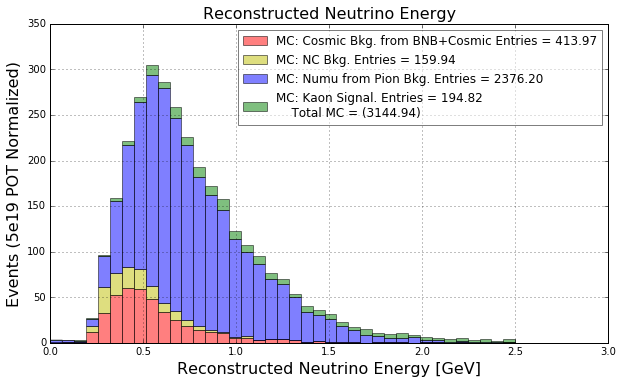

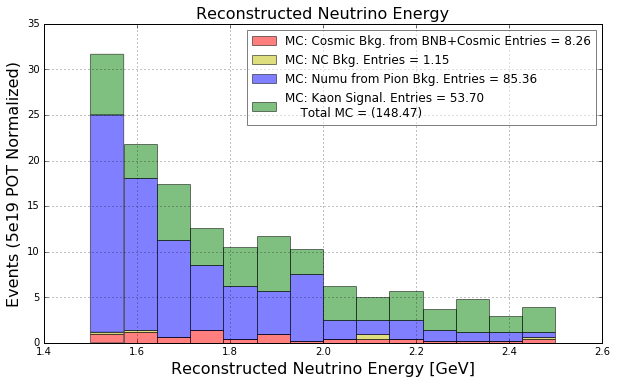

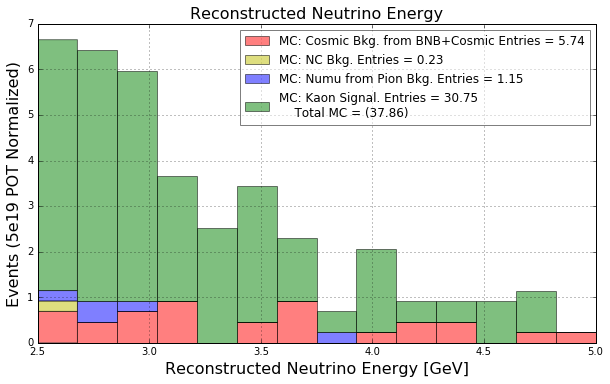

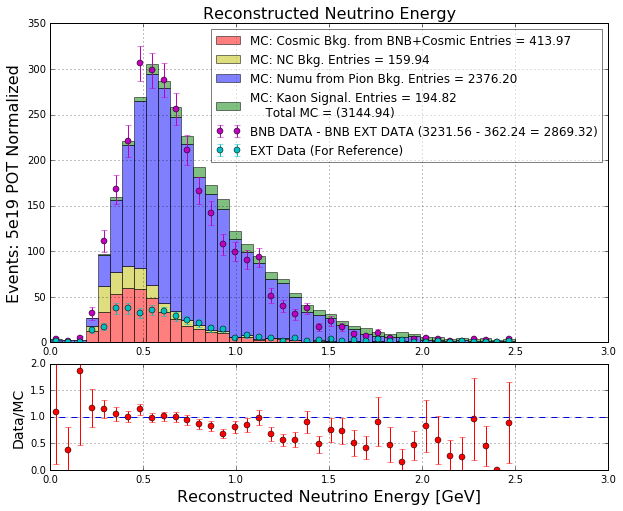

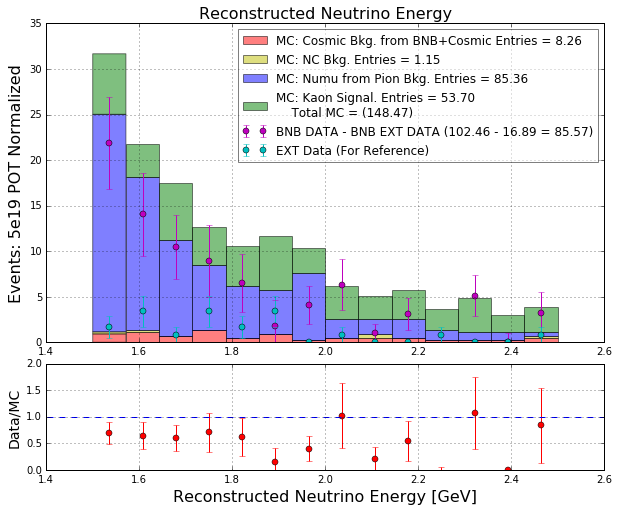

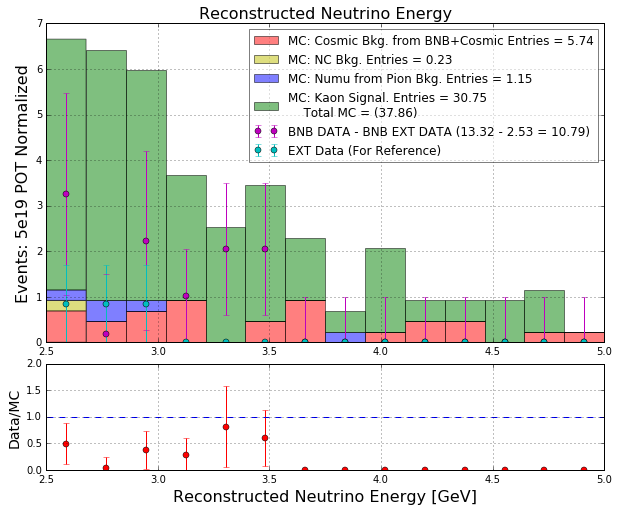

In [15]:
#rosie
mylogy = None
myvar = 'nu_E_estimate'# 'artificial_E_2'
mybins = np.linspace(0,2.5,40)
#mybins = np.linspace(2,8,30)
mytitlebase = 'Reconstructed Neutrino Energy'
myshapeonly = False
myxlabel = 'Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_len_infidvol > 100'
#myquery += ' and longest_trk_cosy > -0.5 and longest_trk_cosy < 0.5'
#myquery += ' and longest_trk_wiggle < 0.02'
#myquery += ' and reco_nu_z < 600'
#myquery += ' and reco_nu_y < 80'
#myquery += ' and longest_track_end_z < 600'

#myquery += ' and longest_trk_contained'
#myquery += ' and second_longest_trk_len > 20.'
#myquery += ' and not MCS_linecut'
#myquery += ' and longest_trk_contained'
#myquery += ' and longest_track_end_x_infidvol > 125.'

print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=False)


mybins = np.linspace(1.5,2.5,15)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=False)


mybins = np.linspace(2.5,5,15)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=False)

mybins = np.linspace(0,2.5,40)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=True)

mybins = np.linspace(1.5,2.5,15)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=True)

mybins = np.linspace(2.5,5,15)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,draw_data=True)


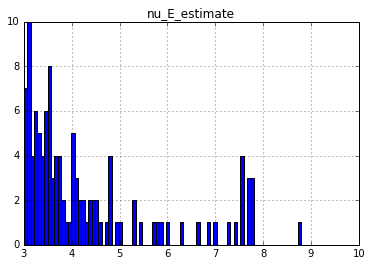

In [91]:
fart = df_dict['mcnu'].hist('nu_E_estimate',bins=np.linspace(3,10,100))
#fart = plt.yscale('log')

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and nu_E_estimate < 2.5
Chisq is 55.277628, DOF is 34, pval is 0.988015
Chisq is 19.796209, DOF is 39, pval is 0.004505


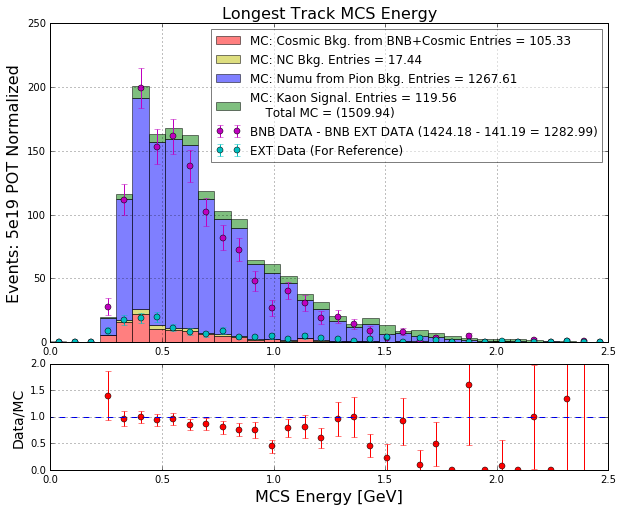

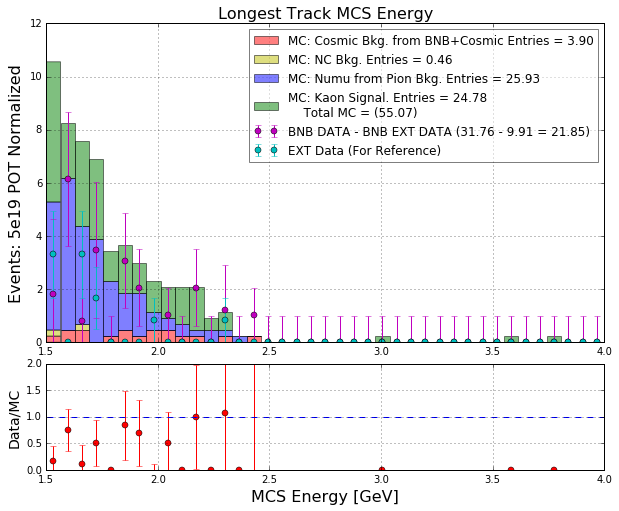

In [18]:
mylogy = None
myvar = 'longest_trk_MCS_mom_chopped'#arbscaled_MConly'#_scaled_MConly#chopped_straightened'#smeared_MC'# 'artificial_E'
mybins = np.linspace(0,2.5,35)
#mybins = np.linspace(2.5,5,20)
mytitlebase = 'Longest Track MCS Energy'
myshapeonly = False
myxlabel = 'MCS Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_len_infidvol > 100'
#myquery += ' and second_longest_trk_len > 50'
#myquery += ' and reco_nu_z > 200'
#myquery += ' and longest_track_end_z < 900'
#myquery += ' and longest_track_end_z < 1000'
#myquery += ' and longest_track_end_y > -80'
#myquery += ' and longest_track_end_y < 80'
#myquery += ' and (longest_track_end_x > 220 or longest_track_end_x < 20)'
#myquery += ' and longest_track_end_x > 30 and longest_track_end_x < 210'
#myquery += ' and reco_nu_x > 30 and reco_nu_x < 210'
myquery += ' and nu_E_estimate < 2.5'
#myquery += ' and (longest_track_end_y > 80 or longest_track_end_y < -80)'
#myquery += ' and longest_track_end_y > -80 and longest_track_end_y < 80'
#myquery += ' and (longest_track_end_z < 50 or longest_track_end_z > 950)'
#myquery += ' and longest_track_end_z < 950'

#myquery += ' and longest_trk_cosy > -0.5 and longest_trk_cosy < 0.5'
#myquery += ' and longest_trk_wiggle < 0.02'
#myquery += ' and longest_trk_theta < 0.5'
#myquery += ' and longest_trk_contained'
#myquery += ' and not MCS_linecut'
#myquery += ' and longest_track_end_x_infidvol > 125.'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(1.5,4,40)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

#mybins = np.linspace(2.0,10,20)
#plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
#                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


[]
longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and longest_trk_len_infidvol > 100 and reco_nu_z > 200


KeyError: 'lengthoverLength'

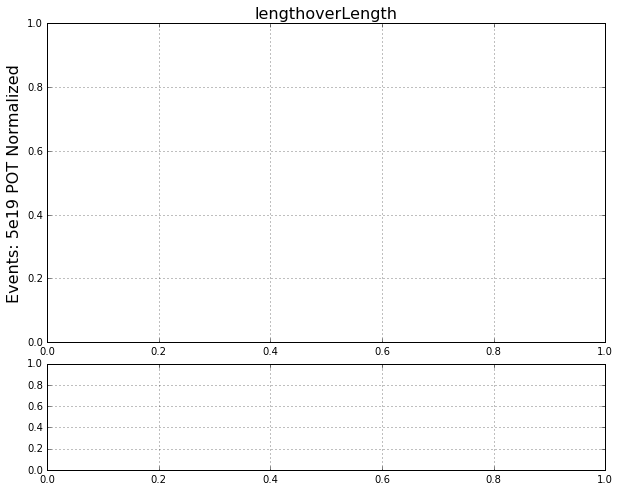

In [31]:
print [x for x in df_dict['mcnu'].columns.values if 'length' in x]
mylogy = None
myvar = 'lengthoverLength'# 'artificial_E'
mybins = np.linspace(0.992,1.001,20)
#mybins = np.linspace(0.95,1,20)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and longest_trk_len_infidvol > 100'
myquery += ' and reco_nu_z > 200'
#myquery += ' and longest_track_end_z_infidvol < 600'
#myquery += ' and longest_trk_cosy > -0.5 and longest_trk_cosy < 0.5'
#myquery += ' and longest_trk_theta < 0.5'
#myquery += ' and not longest_trk_contained'
#myquery += ' and longest_track_end_x_infidvol > 125.'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and longest_trk_len_infidvol > 250 and longest_trk_cosy > -0.1 and longest_trk_cosy < 0.1 and longest_trk_theta < 0.1


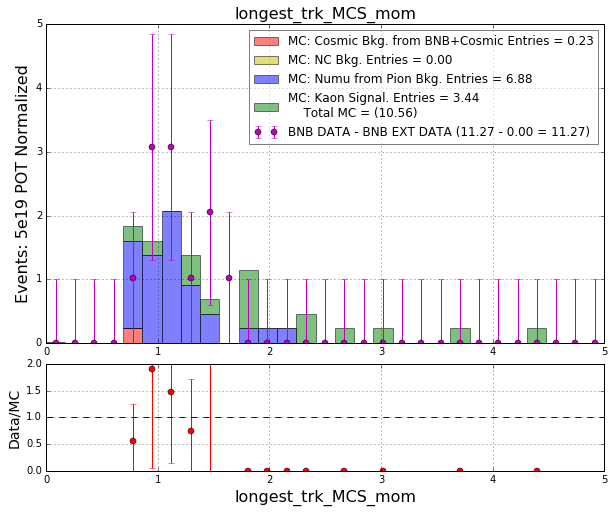

In [32]:
### mylogy = None
myvar = 'longest_trk_MCS_mom'# 'artificial_E'
mybins = np.linspace(0,5,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and longest_trk_len_infidvol > 250'
myquery += ' and longest_trk_cosy > -0.1 and longest_trk_cosy < 0.1'
myquery += ' and longest_trk_theta < 0.1'
#myquery += ' and not longest_trk_contained'
#myquery += ' and longest_track_end_x_infidvol > 125.'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995
Chisq is 41.476384, DOF is 16, pval is 0.999528
Chisq is 24.003486, DOF is 19, pval is 0.803981
Chisq is 68.048347, DOF is 31, pval is 0.999863
Chisq is 18.635236, DOF is 9, pval is 0.971521
Chisq is 38.927327, DOF is 19, pval is 0.995486
Chisq is 16.567887, DOF is 19, pval is 0.380883
Chisq is 53.571593, DOF is 31, pval is 0.992855
Chisq is 23.709090, DOF is 19, pval is 0.792451
Chisq is 14.907622, DOF is 9, pval is 0.906495


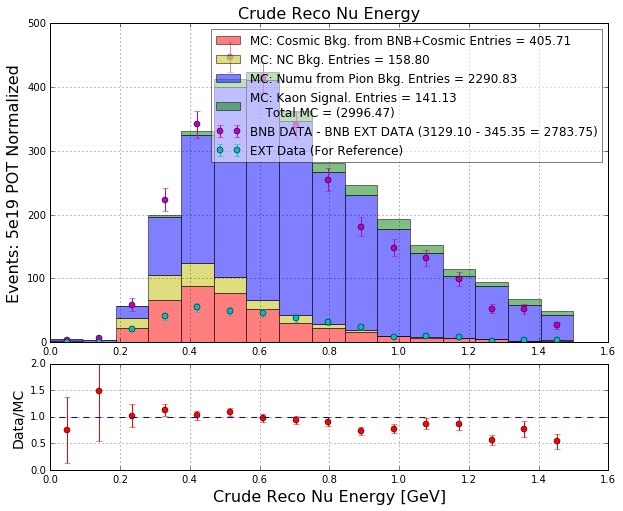

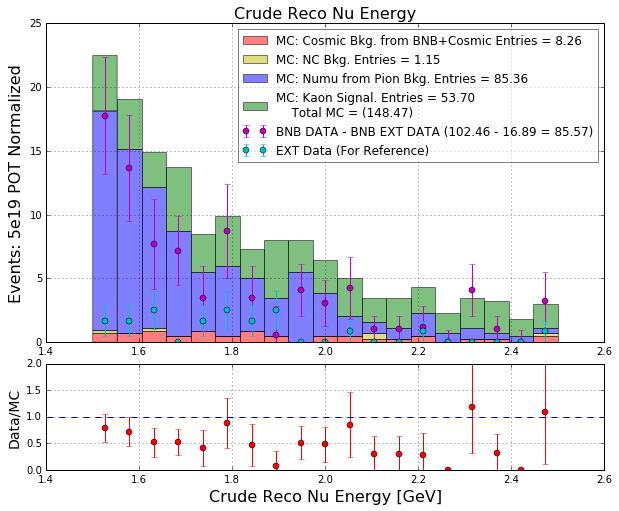

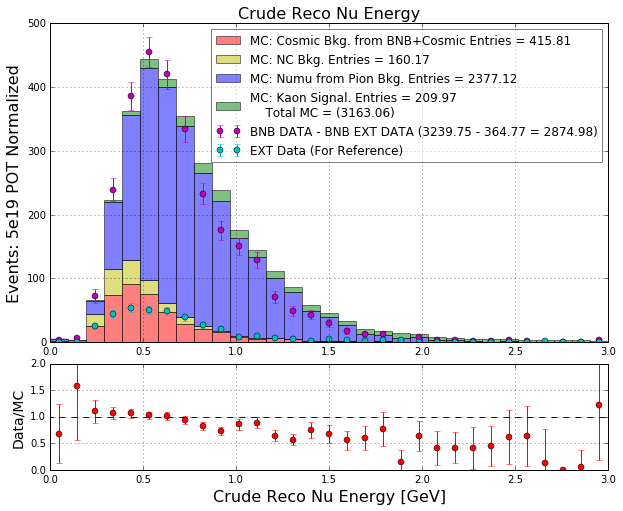

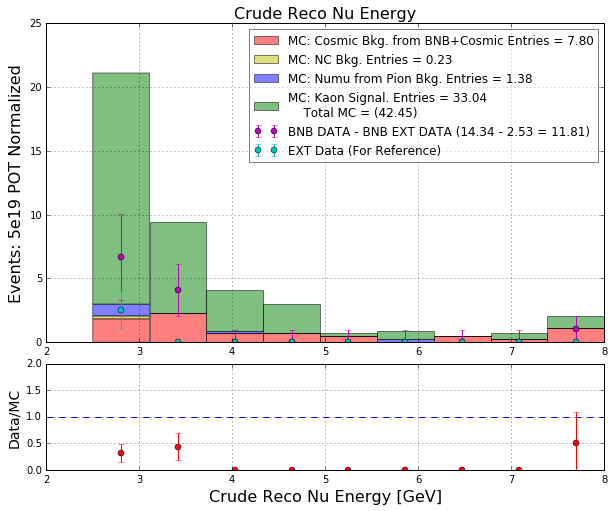

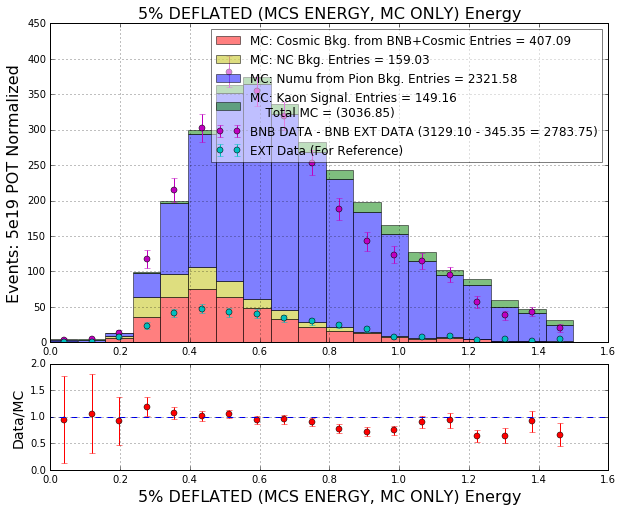

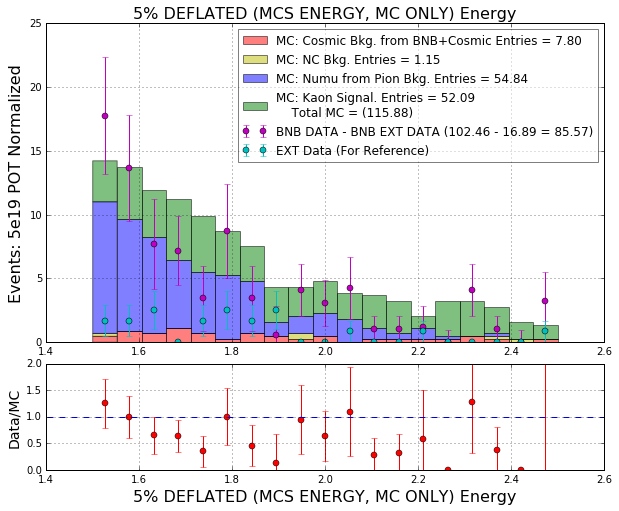

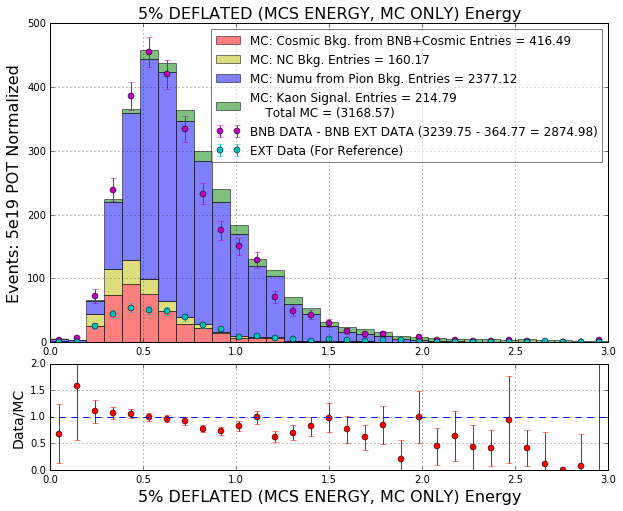

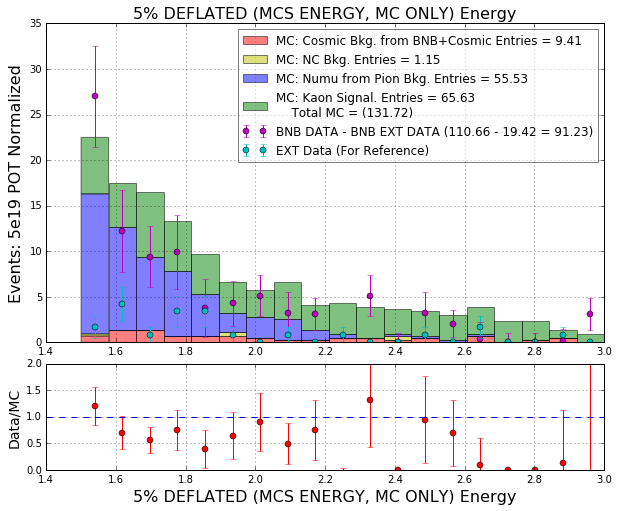

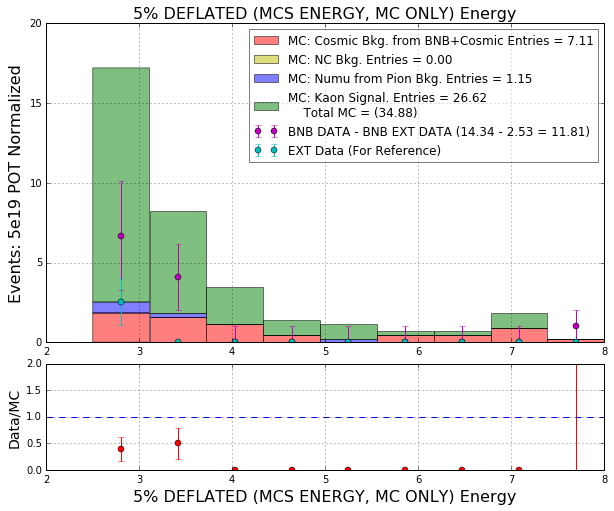

In [33]:
### mylogy = None
myvar = 'nu_E_estimate'# 'artificial_E'
mybins = np.linspace(0,1.5,17)
mytitlebase = 'Crude Reco Nu Energy'
myshapeonly = False
myxlabel = 'Crude Reco Nu Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(1.5,2.5,20)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(0,3,32)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(2.5,8,10)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)



myvar = 'artificial_E_3'
mybins = np.linspace(0,1.5,20)
mytitlebase = '5% DEFLATED (MCS ENERGY, MC ONLY) Energy'
myxlabel = mytitlebase
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(1.5,2.5,20)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(0,3,32)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(1.5,3,20)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mybins = np.linspace(2.5,8,10)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

KeyError: '_oh'

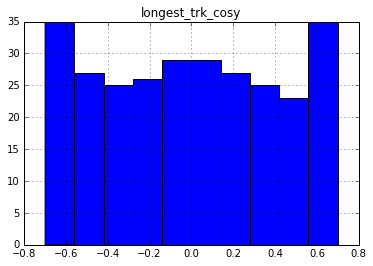

In [34]:
fuck = 'longest_trk_len_infidvol > 100. and longest_trk_cosy < 0.7 '
fuck += 'and longest_trk_cosy > -0.7 and longest_tracks_dotprod_trkendpoints > -0.995'
df_dict['mcnu'].query(fuck + ' and not correct_ID').hist('longest_trk_cosy')

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and longest_track_end_z < 600
Chisq is 14.384120, DOF is 19, pval is 0.239144
longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and longest_track_end_z < 600
Chisq is 12.191281, DOF is 19, pval is 0.122713
longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995 and longest_track_end_z < 600
Chisq is 27.176713, DOF is 19, pval is 0.899396


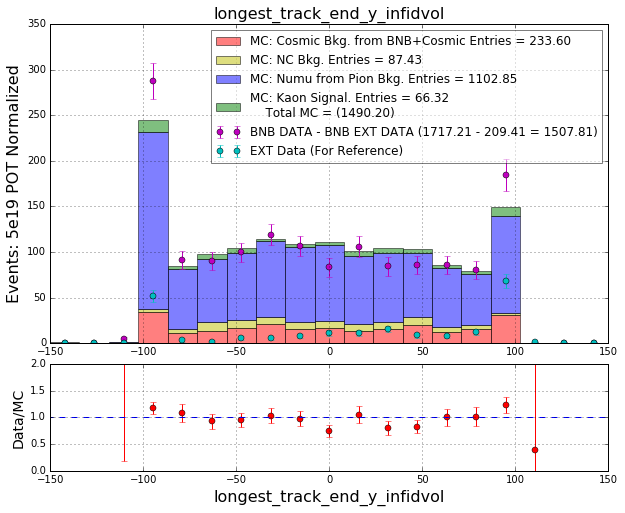

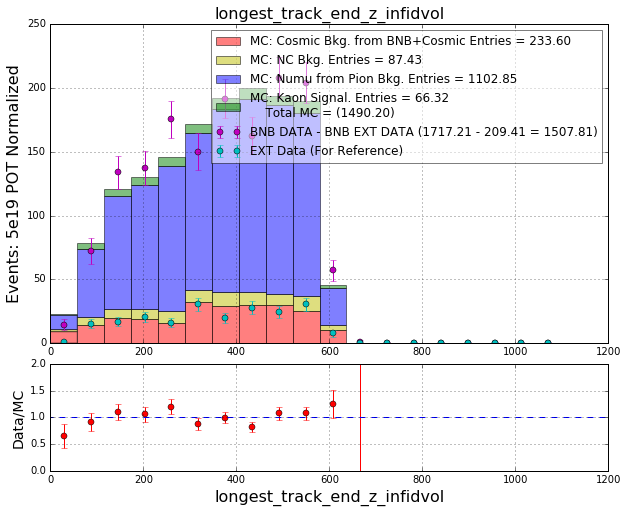

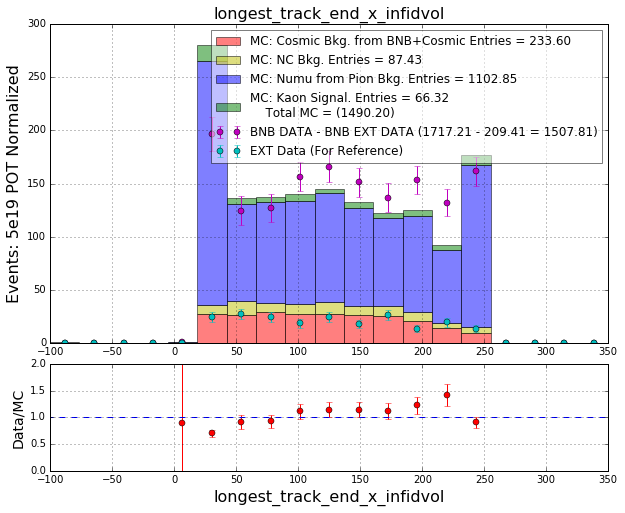

In [35]:
# mycuts = ['longest_trk_len_infidvol > 15.',
#          'nu_E_estimate > 2.5',
#          'longest_tracks_dotprod_trkendpoints > -0.995',
#         'not longest_trk_contained',
#         '(longest_track_end_z_infidvol < 600 or longest_track_end_z_infidvol > 800)']

mylogy = None
myvar = 'longest_track_end_y_infidvol'
mybins = np.linspace(-150,150,20)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and longest_track_end_z < 600'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mylogy = None
myvar = 'longest_track_end_z_infidvol'
mybins = np.linspace(0,1100,20)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and longest_track_end_z < 600'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mylogy = None
myvar = 'longest_track_end_x_infidvol'
mybins = np.linspace(-100,350,20)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and longest_track_end_z < 600'
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
#mycuts = ['longest_trk_len_infidvol > 15.',
#          'nu_E_estimate > 2.5',
#          'longest_tracks_dotprod_trkendpoints > -0.995',
#         #'not longest_trk_contained',
#         '(longest_track_end_z_infidvol < 600 or longest_track_end_z_infidvol > 800)',
#         '(reco_nu_z < 600 or reco_nu_z > 800)']

mylogy = None
myvar = 'reco_nu_y'
mybins = np.linspace(-150,150,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mylogy = None
myvar = 'reco_nu_z'
mybins = np.linspace(0,1100,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

mylogy = None
myvar = 'reco_nu_x'
mybins = np.linspace(-100,350,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995
Chisq is 43.194356, DOF is 39, pval is 0.703264


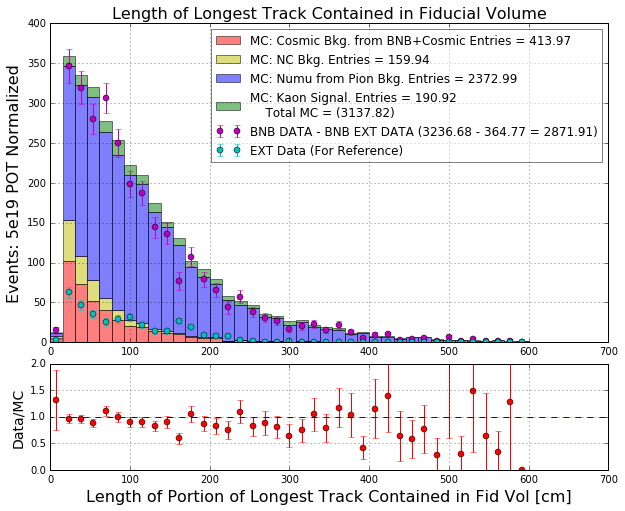

In [106]:
mylogy = None
myvar = 'longest_trk_len_infidvol'
mybins = np.linspace(0,600,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = 'Length of Portion of Longest Track Contained in Fid Vol [cm]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_wiggle < 0.02'
#myquery += ' and longest_trk_cosy > -0.35 and longest_trk_cosy < 0.35'
#myquery += ' and longest_track_end_z_infidvol < 600'
#myquery += ' and longest_trk_theta < 0.5'
print myquery
mytitle = 'Length of Longest Track Contained in Fiducial Volume'
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)



In [ ]:
print df_dict['mcnu'].columns.values

longest_trk_len_infidvol > 15. and longest_tracks_dotprod_trkendpoints > -0.995
Chisq is 79.177308, DOF is 25, pval is 1.000000


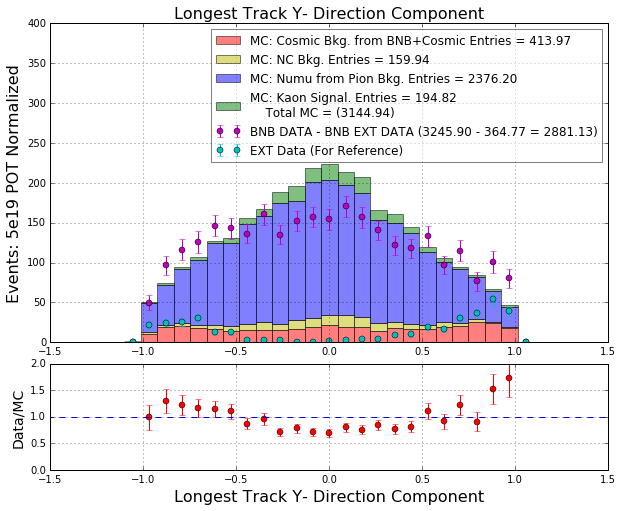

In [110]:
mylogy = None
myvar = 'longest_trk_cosy'
mybins = np.linspace(-1.1,1.1,26)
mytitlebase = 'Longest Track Y- Direction Component'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = (0,400)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_len_infidvol > 200.'
#myquery += ' and n_associated_tracks > 2'
#myquery += ' and second_longest_trk_len > 30'
print myquery

mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)


Chisq is 99.872599, DOF is 39, pval is 1.000000
Chisq is 43.835636, DOF is 39, pval is 0.726158
Chisq is 18.933733, DOF is 39, pval is 0.002808
Chisq is 87.982375, DOF is 19, pval is 1.000000
Chisq is 14.632637, DOF is 19, pval is 0.254357
Chisq is 12.633605, DOF is 19, pval is 0.143212


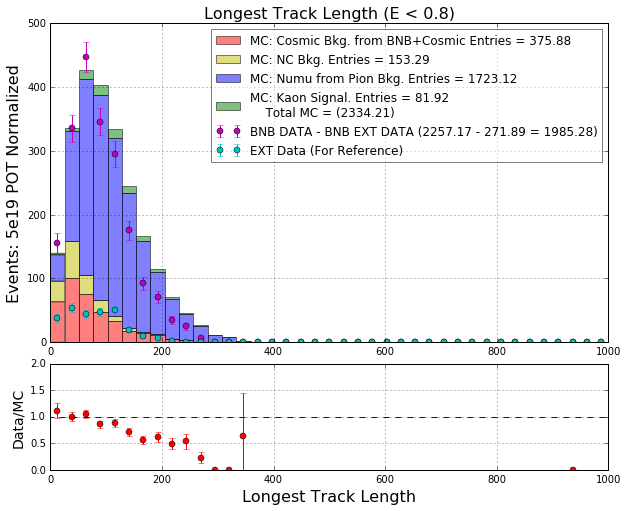

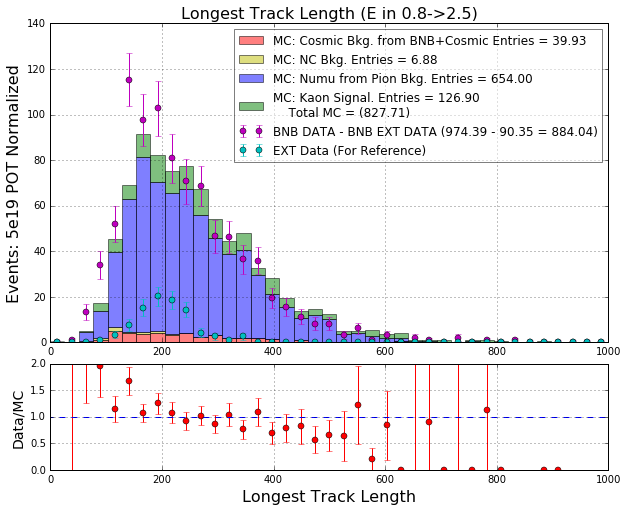

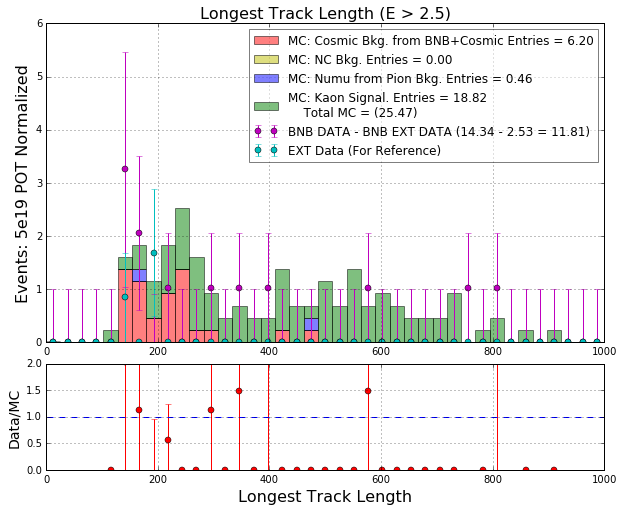

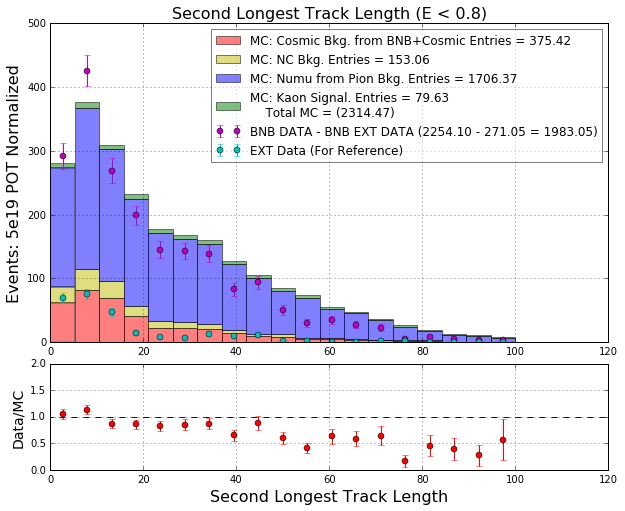

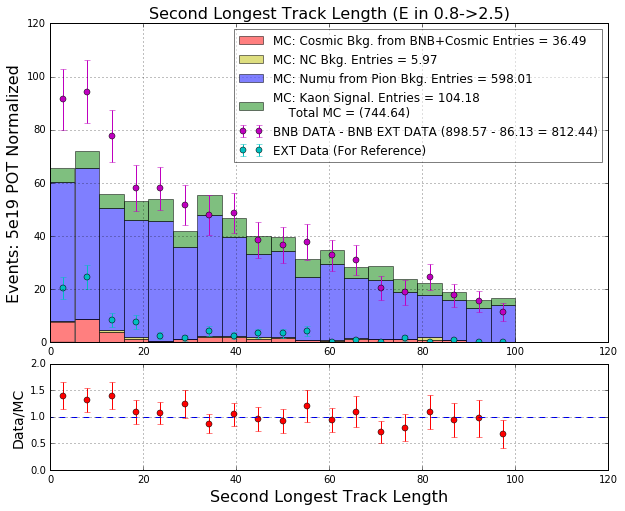

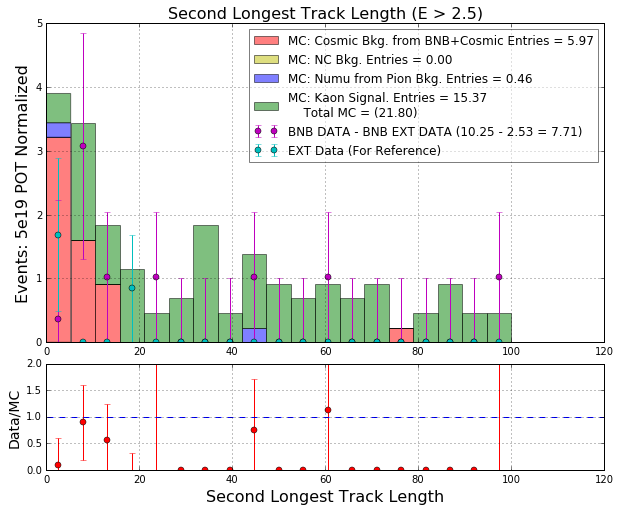

In [99]:
mylogy = None
myvar = 'longest_trk_len'
mybins = np.linspace(0,1000,40)
mytitlebase = 'Longest Track Length'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparisonEnergyRegions(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)



mylogy = None
myvar = 'second_longest_trk_len'
mybins = np.linspace(0,100,20)
mytitlebase = 'Second Longest Track Length'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparisonEnergyRegions(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


Chisq is 69.291979, DOF is 25, pval is 0.999995


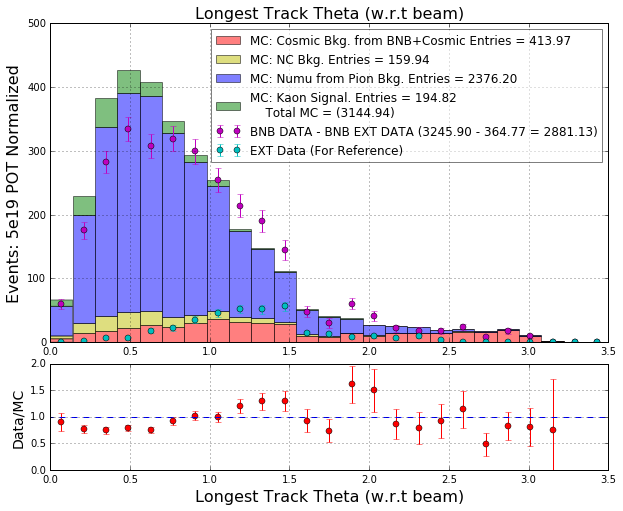

In [111]:
mylogy = None
myvar = 'longest_trk_theta'
mybins = np.linspace(0,3.5,26)
#mybins = np.linspace(0,0.5,10)
mytitlebase = 'Longest Track Theta (w.r.t beam)'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_len_infidvol > 200.'
#myquery += ' and n_associated_tracks > 2'
#myquery += ' and second_longest_trk_len > 30'
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)


Chisq is 51.512477, DOF is 29, pval is 0.993825


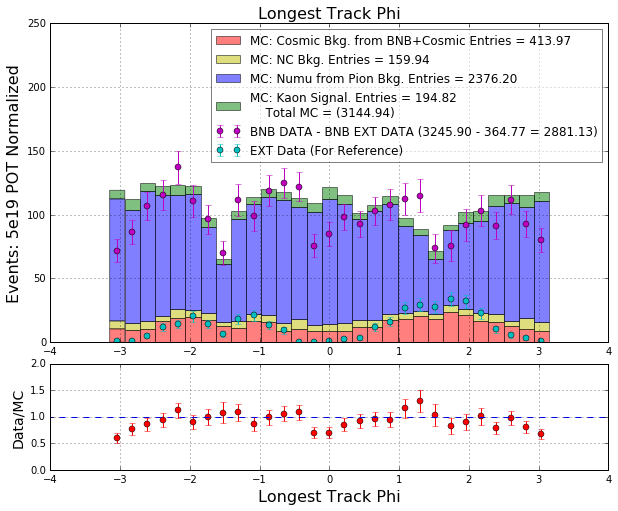

In [115]:
mylogy = None
myvar = 'longest_trk_phi'
mybins = np.linspace(-3.15,3.15,30)
mytitlebase = 'Longest Track Phi'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = (0,250)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)


In [ ]:
scalefactor = 1.0#0.95#.875
df_dict['mcnu']['temp_scaled_MCS'] = df_dict['mcnu']['longest_trk_MCS_mom'] * scalefactor
df_dict['datanu']['temp_scaled_MCS'] = df_dict['datanu']['longest_trk_MCS_mom'] 
df_dict['databkg']['temp_scaled_MCS'] = df_dict['databkg']['longest_trk_MCS_mom'] 

mylogy = None
myvar = 'temp_scaled_MCS'
mybins = np.linspace(0,8,20)
mytitlebase = 'Longest Track MCS Momentum [MC SCALED %s]' % scalefactor
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = 'longest_trk_len_infidvol > 100. and longest_trk_cosy < 0.7 and longest_trk_cosy > -0.7'
myquery += ' and longest_tracks_dotprod_trkendpoints > -0.995'
myquery += ' and longest_trk_theta < 0.5'
#myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and longest_trk_len_infidvol > 200.'
#myquery += ' and second_longest_trk_len > 20'
#myquery += ' and nu_E_estimate > 2.5'

print myquery
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


Chisq is 65.347885, DOF is 39, pval is 0.994849


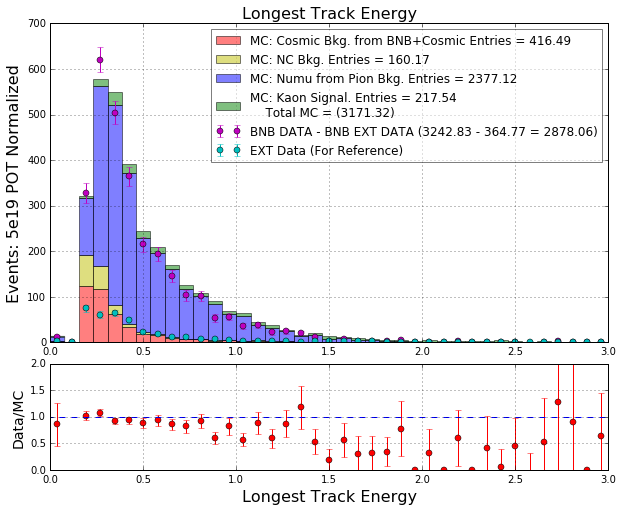

In [103]:
mylogy = None
myvar = 'E_lepton'
mybins = np.linspace(0,3,40)
mytitlebase = 'Longest Track Energy'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only = True)


In [ ]:
mylogy = None
myvar = 'E_hadrons'
mybins = np.linspace(0,1.0,26)
mytitlebase = 'Hadron Energy (E sans longest track)'
myshapeonly = False
myxlabel = mytitlebase
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparisonLengthRegions(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


Chisq is 23.790028, DOF is 6, pval is 0.999429


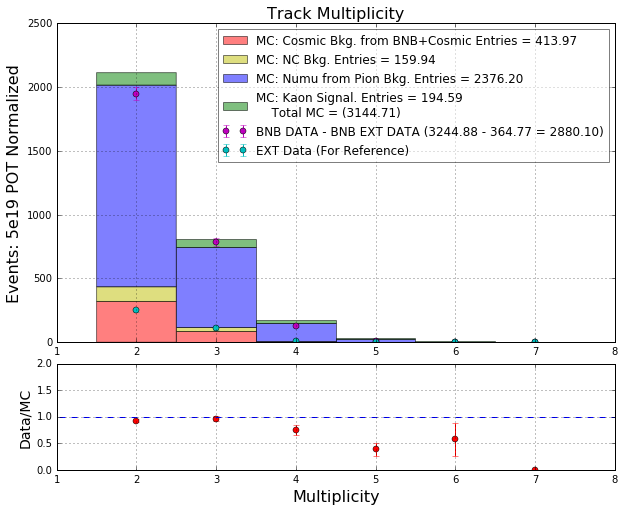

In [118]:
mylogy = None
myvar = 'n_associated_tracks'
mybins = np.linspace(1.5,7.5,7)
mytitlebase = 'Multiplicity'
myshapeonly = False
myxlabel = 'Multiplicity'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#myquery += ' and nu_E_estimate > 1'
mytitle = 'Track Multiplicity'

#def loopCutsPlots(myvar, mybins, mytitlebase, myshapeonly, myxlabel, myylabel, mylogy, myylims = None):

plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)


In [ ]:
mylogy = None
myvar = 'n_associated_tracks'
mybins = np.linspace(0.5,7.5,8)
mytitlebase = 'Multiplicity'
myshapeonly = True
myxlabel = 'Multiplicity'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None
for mycut in [0, 0.5, 1.0, 1.5, 2.0, 2.5]:
    myquery = 'nu_E_estimate > %0.2f' % mycut
    mytitle = mytitlebase + '(%s)'%myquery
    
    plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                         myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
goodquery = 'n_associated_tracks > 2 and nu_E_estimate > 2.5 and correct_ID'
badquery = 'n_associated_tracks > 2 and nu_E_estimate > 2.5 and not correct_ID'
print len(df_dict['mcnu'].query(goodquery))
print len(df_dict['mcnu'].query(badquery))

Chisq is 27.222591, DOF is 2, pval is 0.999999


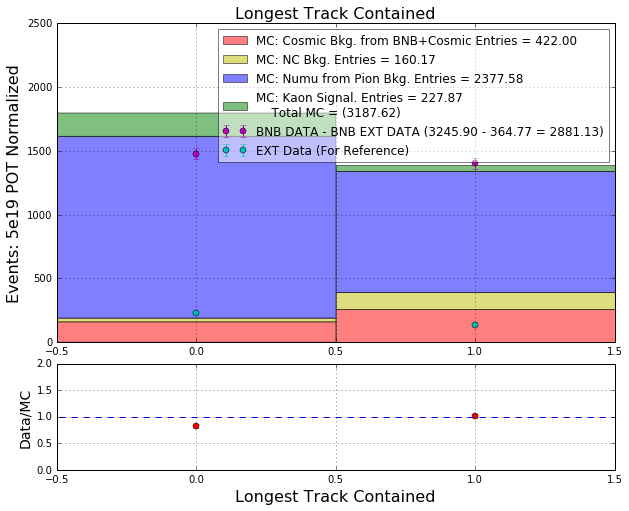

In [120]:
mylogy = None
myvar = 'longest_trk_contained'
mybins = np.linspace(-0.5,1.5,3)
mytitlebase = 'Longest Track Contained'
myshapeonly = False
myxlabel = 'Longest Track Contained'
myylabel = 'Events (5e19 POT Normalized)'
myylims = (0,2500)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

#kazu

In [ ]:
mylogy = None
myvar = 'MCS_ratio'
mybins = np.linspace(0,1,26)
mytitlebase = myvar
myshapeonly = False
myxlabel = 'Fraction of nu Energy from MCS'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,75)
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
mytitle = mytitlebase
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:

mylogy = None
myvar = 'nu_E_estimate'
mybins = np.linspace(0,2.5,26)
mytitlebase = 'Crude Reco Nu Energy'
myshapeonly = False
myxlabel = 'Crude Reco Nu Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


mylogy = None
myvar = 'nu_E_estimate'
mybins = np.linspace(1.,2.5,16)
mytitlebase = 'Crude Reco Nu Energy'
myshapeonly = False
myxlabel = 'Crude Reco Nu Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.2)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)

mylogy = None
myvar = 'nu_E_estimate'
mybins = np.linspace(2.5,10,10)
mytitlebase = 'Crude Reco Nu Energy'
myshapeonly = False
myxlabel = 'Crude Reco Nu Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.55)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


In [ ]:
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
myquery += ' and nu_E_estimate > 0'
mybins = np.linspace(300,1000,50)
df_dict['mcnu'].query(myquery).hist('longest_trk_len_infidvol',bins=mybins)
df_dict['datanu'].query(myquery).hist('longest_trk_len_infidvol',bins=mybins)

In [ ]:
df_dict['mcnu'].hist('E_lepton')

In [ ]:

mylogy = True
myvar = 'E_hadrons'
mybins = np.linspace(0,1.5,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.55)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


mylogy = True
myvar = 'E_lepton'
mybins = np.linspace(0,4,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.55)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


In [ ]:
#mylogy = None
#myvar = 'longest_track_end_x_infidvol'
#mybins = np.linspace(-10,270,30)
#mytitlebase = myvar
#myshapeonly = False
#myxlabel = myvar
#myylabel = 'Events (5e19 POT Normalized)'
#loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
#
#mylogy = None
#myvar = 'longest_track_end_y_infidvol'
#mybins = np.linspace(-150,150,30)
#mytitlebase = myvar
#myshapeonly = False
#myxlabel = myvar
#myylabel = 'Events (5e19 POT Normalized)'
#loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
#
#mylogy = None
#myvar = 'longest_track_end_z_infidvol'
#mybins = np.linspace(0,1100,100)
#mytitlebase = myvar
#myshapeonly = False
#myxlabel = myvar
#myylabel = 'Events (5e19 POT Normalized)'
#loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)
#


In [ ]:
mylogy = None
myvar = 'n_associated_tracks'
mybins = np.linspace(-0.5,10.5,12)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.8)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


In [ ]:
mylogy = None
myvar = 'longest_tracks_dotprod_trkendpoints'
mybins = np.linspace(-5000000,5000000,50)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
#loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


Chisq is 47.614720, DOF is 29, pval is 0.983891


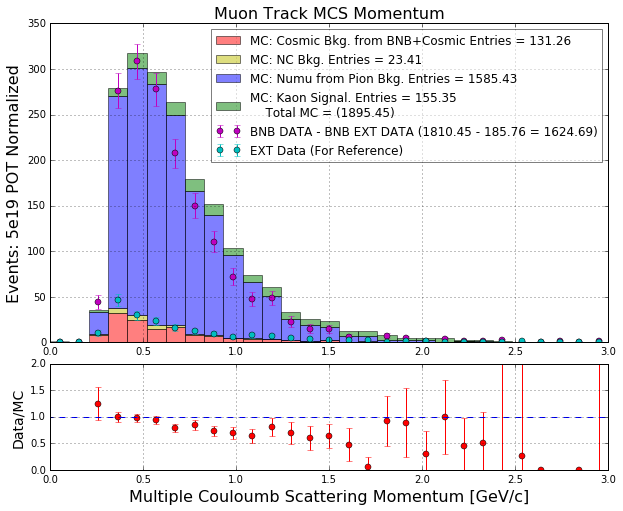

In [125]:
mylogy = None
myvar = 'longest_trk_MCS_mom'
mybins = np.linspace(0,3,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = 'Multiple Couloumb Scattering Momentum [GeV/c]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None
mytitle = 'Muon Track MCS Momentum'
myquery = str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims,\
                          myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,sideband_only=True)

In [ ]:
mylogy = None
myvar = 'longest_trk_theta'
mybins = np.linspace(0,3.14,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
mylogy = None
myvar = 'longest_trk_phi'
mybins = np.linspace(-3.141,3.141,30)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
mylogy = None
myvar = 'CCQE_E'
mybins = np.linspace(0,8,30)
mytitlebase = 'CCQE_E'
myshapeonly = False
myxlabel = 'CCQE_E'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
mylogy = None
myvar = 'longest_trk_len'
mybins = np.linspace(0,1000,41)
mytitlebase = 'Longest Track Length'
myshapeonly = False
myxlabel = 'Length of Longest Associated Track [cm]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.35)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)

In [ ]:
mylogy = True
myvar = 'longest_trk_len_infidvol'
mybins = np.linspace(0,1000,51)
mytitlebase = 'Longest Track Length (Contained in Fid Vol)'
myshapeonly = False
myxlabel = 'Length of Longest Associated Track (Portion Contained) [cm]'
myylabel = 'Events (5e19 POT Normalized)'
myylims = None#(0,0.125)
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy,myylims=myylims)


In [ ]:
mylogy = None
myvar = 'longest_trk_contained'
mybins = np.linspace(-0.5,1.5,3)
mytitlebase = 'Longest Track Contained in Fid Vol?'
myshapeonly = False
myxlabel = 'Longest Track Contained in Fid Vol?'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
mylogy = None
myvar = 'second_longest_trk_len'
mybins = np.linspace(0,100,40)
mytitlebase = 'Second Longest Track Length'
myshapeonly = False
myxlabel = 'Length of Second Longest Associated Track [cm]'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:
querybase = 'nu_E_estimate > 2.5'
mcdenom = len(df_dict['mcnu'].query(querybase + ' and correct_ID'))
datadenom = len(df_dict['datanu'].query(querybase))
bkgdenom = len(df_dict['databkg'].query(querybase))

querybasebelow = 'nu_E_estimate < 2.5'
mcdenombelow = len(df_dict['mcnu'].query(querybasebelow + ' and correct_ID'))
datadenombelow = len(df_dict['datanu'].query(querybasebelow))
bkgdenombelow = len(df_dict['databkg'].query(querybasebelow))


for mycut in mycuts:
    print "Cut: %s" % mycut
    mcnum = len(df_dict['mcnu'].query(querybase + ' and correct_ID and ' + mycut))
    datanum = len(df_dict['datanu'].query(querybase + ' and ' + mycut))
    bkgnum = len(df_dict['databkg'].query(querybase + ' and ' + mycut))
    mcnumbelow = len(df_dict['mcnu'].query(querybasebelow + ' and correct_ID and ' + mycut))
    datanumbelow = len(df_dict['datanu'].query(querybasebelow + ' and ' + mycut))
    bkgnumbelow = len(df_dict['databkg'].query(querybasebelow + ' and ' + mycut))
    print "  Fraction MC remaining above 2.5 reco E =", float(mcnum)/float(mcdenom)
    print "  Fraction MC remaining below 2.5 reco E =", float(mcnumbelow)/float(mcdenombelow)
    if datadenom:
        print "  Fraction data remaining above 2.5 reco E =", float(datanum)/float(datadenom)
    if datadenombelow:
        print "  Fraction data remaining below 2.5 reco E =", float(datanumbelow)/float(datadenombelow)
    if bkgdenom:
        print "  Fraction bkg remaining above 2.5 reco E =", float(bkgnum)/float(bkgdenom)
    if bkgdenombelow:
        print "  Fraction bkg remaining below 2.5 reco E =", float(bkgnumbelow)/float(bkgdenombelow)
    

In [ ]:
mylogy = None
myvar = 'longest_trk_len'
mybins = np.linspace(0,1000,20)
mytitlebase = 'Longest Track Length'
myshapeonly = False
myxlabel = 'Length of Longest Associated Track [cm]'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

myvar = 'longest_trk_len'
mybins = np.linspace(0,1000,10)
dummy = 'Longest Track Length (Misc Cuts)'
myshapeonly = False
myxlabel = 'Length of Longest Associated Track [cm]'
myylabel = 'Events (5e19 POT Normalized)'
#myquery = 'longest_trk_cosy < 0.5 and longest_trk_cosy > -0.5'
myquery = ' longest_tracks_dotprod_trkendpoints > -0.5'
#myquery += ' and longest_trk_len > 100.'
#myquery += ' and second_longest_trk_len > 16.'
myquery += ' and nu_E_estimate > 2.5'
#myquery += ' and n_reco_nu_in_evt == 1'
plotVariableComparison(myvar,mybins,myquery,dummy,myshapeonly,myxlabel=myxlabel,myylabel=myylabel)

In [ ]:
mylogy = True
myvar = 'n_associated_tracks'
mytitlebase = myvar
mybins = np.linspace(-0.5,8.5,10)
dummy = 'Multiplicity'
myshapeonly = False
myxlabel = 'Multiplicity'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


In [ ]:

mylogy = None
myvar = 'E_lepton'
mybins = np.linspace(0,8,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)


mylogy = None
myvar = 'E_hadrons'
mybins = np.linspace(0,3,40)
mytitlebase = myvar
myshapeonly = False
myxlabel = myvar
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)



In [ ]:

myvar = 'longest_trk_MCS_mom'
mybins = np.linspace(1,6,30)
dummy = 'longest_trk_MCS_mom'
myshapeonly = True
myxlabel = 'longest_trk_MCS_mom [GEV]'
myylabel = 'Events (5e19 POT Normalized)'
mytitlebase = 'longest_trk_MCS_mom'
myylims = (0,0.3)
mylogy = None

loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy=mylogy,myylims=myylims)

In [ ]:
mcnum = float(np.sum(df_dict['mcnu']['longest_trk_contained'].values))
mcdenom = float(len(df_dict['mcnu']['longest_trk_contained'].values))
datanum = float(np.sum(df_dict['datanu']['longest_trk_contained'].values))
datadenom = float(len(df_dict['datanu']['longest_trk_contained'].values))

print "Fraction of MC events with longest track contained: %f" % (mcnum/mcdenom)
print "Fraction of Data events with longest track contained: %f" % (datanum/datadenom)

In [ ]:

myvar = 'longest_trk_contained'
mybins = np.linspace(-0.5,1.5,3)
dummy = 'Longest Track Contained'
myshapeonly = False
myxlabel = 'Longest Track Contained'
myylabel = 'Events (5e19 POT Normalized)'
myquery = 'longest_trk_cosy < 0.5 and longest_trk_cosy > -0.5'
#myquery += ' and longest_tracks_dotprod_trkendpoints > -0.5'
#myquery += ' and longest_trk_len > 100.'
#myquery += ' and second_longest_trk_len > 16.'
#myquery += ' and nu_E_estimate > 2.5'
plotVariableComparison(myvar,mybins,myquery,dummy,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=None)

In [ ]:
mylogy = None
myvar = 'nu_E_estimate'
mybins = np.linspace(0,10,30)
dummy = 'Estimated Nu Energy (Tight y- Fid Vol)'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = 'longest_track_end_y > -70 and longest_track_end_y < 70'
#plotVariableComparison(myvar,mybins,myquery,dummy,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

myvar = 'nu_E_estimate'
mybins = np.linspace(0,10,30)
dummy = 'Estimated Nu Energy (Tight z- Fid Vol)'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = 'longest_track_end_z > 30 and longest_track_end_z < 900'
#plotVariableComparison(myvar,mybins,myquery,dummy,myshapeonly,myxlabel=myxlabel,myylabel=myylabel,mylogy=mylogy)

myvar = 'nu_E_estimate'
mybins = np.linspace(0,10,30)
mytitlebase = 'Estimated Nu Energy'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy=mylogy)

In [ ]:
fuck = 'correct_ID and true_nu_E > 2.5 and not true_nu_CCNC'
df_dict['mcnu'].query(fuck).hist('nu_E_estimate',bins=np.linspace(0,7,50))
df_dict['mcnu'].query(fuck).hist('true_nu_mode',bins=np.linspace(-0.5,3.5,5))
df_dict['mcnu'].query(fuck).hist('longest_trk_MCS_mom',bins=np.linspace(0,10,50))
df_dict['mcnu'].query(fuck).hist('true_lepton_momentum',bins=np.linspace(0,10,50))
print df_dict['mcnu'].columns.values

In [ ]:
plt.figure(figsize=(10,6))
mybins=np.linspace(0,2000,30)
fuck = df_dict['mcnu'].query('correct_ID').hist('brightest_BSW_flash_PE',bins=mybins)
plt.figure(figsize=(10,6))
myquery = str.join(' and ',mycuts)
print myquery
fuck = df_dict['mcnu'].query('correct_ID and %s'%myquery).hist('brightest_BSW_flash_PE',bins=mybins)

In [ ]:
myvar = 'brightest_BSW_flash_PE'
mylogy = None
mybins = np.linspace(0,2000,30)
mytitlebase = 'PE of Brightest Flash in BSW'
myshapeonly = False
myxlabel = 'PE of Brightest Flash in BSW'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy=mylogy)


#BSW_flash_z_range

In [ ]:
myvar = 'BSW_flash_z_range'
mylogy = None
mybins = np.linspace(0,1000,300)
mytitlebase = 'Z-Range of All Flashes in BSW'
myshapeonly = False
myxlabel = 'Z-Range of All Flashes in BSW [cm]'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy=mylogy)

In [ ]:
print 2.1*200*29000*0.01*0.01

In [ ]:
myvar = 'longest_trk_costheta'
mylogy = None
mybins = np.linspace(-1,1,20)
mytitlebase = 'Longest Track CosTheta'
myshapeonly = False
myxlabel = 'Cos(Theta) of Longest Track (w.r.t. Beam)'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy)

In [ ]:
mybins = np.linspace(0,6,100)
fuck = df_dict['mcnu'].hist('true_nu_E',bins=mybins)
fuck = df_dict['mcnu'].query('nu_E_estimate > 2.5').hist('true_nu_E',bins=mybins)


In [ ]:

##print df_dict['mcnu'].columns.values
#plt.figure(figsize=(10,6))
#myx = df_dict['mcnu'].query(querybase + ' and ' + morequery)['true_nu_E']
#myy = df_dict['mcnu'].query(querybase + ' and ' + morequery)['tot_E_mctracks']
##myy += df_dict['mcnu'].query(querybase + ' and ' + morequery)['tot_E_mcshowers']
#fuck = plt.hist2d(x=myx,y=myy,bins=np.linspace(0,6,100),cmin=1)
#plt.grid(True)
#fart = plt.ylabel("MCTrack Energy [GeV]",fontsize=16)
#fart = plt.xlabel("True Neutrino Energy [GeV]",fontsize=16)
##penispenis

In [ ]:
print df_dict['mcnu'].columns.values

In [ ]:
#tonguepunchfartbox
plt.figure(figsize=(5,5))
myx = df_dict['datanu'].query('longest_trk_contained and longest_trk_len > 100 and not MCS_linecut')['longest_trk_MCS_mom'].values
myy = df_dict['datanu'].query('longest_trk_contained and longest_trk_len > 100 and not MCS_linecut')['longest_trk_spline_mom'].values / 1000. + 0.106
fuck = plt.hist2d(x=myx,y=myy,bins=np.linspace(0,3,100),cmin=1)
plt.xlabel('MCS Momentum [GeV]',fontsize=16)
plt.ylabel('Spline Momentum [GeV]',fontsize=16)
plt.grid(True)
#abcdefg
blah = np.polyfit(myx,myy,1)
p = np.poly1d(blah)
xp = np.linspace(0,3,100)
poop = plt.plot(xp, p(xp), 'g-',linewidth=3, label='Linear Poly Fit')
print p


plt.figure(figsize=(5,5))
myx = df_dict['mcnu'].query('longest_trk_contained and longest_trk_len_infidvol > 100 and not MCS_linecut')['longest_trk_MCS_mom'].values
#myx *= (0.76997739/0.74431758)
myy = df_dict['mcnu'].query('longest_trk_contained and longest_trk_len_infidvol > 100 and not MCS_linecut')['longest_trk_spline_mom'].values / 1000.
fuck = plt.hist2d(x=myx,y=myy,bins=np.linspace(0,3,100),cmin=1)
plt.xlabel('MCS Momentum [GeV]',fontsize=16)
plt.ylabel('Spline Momentum [GeV]',fontsize=16)
plt.grid(True)
blah = np.polyfit(myx,myy,1)
p = np.poly1d(blah)
xp = np.linspace(0,3,100)
poop = plt.plot(xp, p(xp), 'g-',linewidth=3, label='Linear Poly Fit')
print p

In [ ]:
plt.figure(figsize=(10,6))
mybins = np.linspace(0,8,50)
myx1 = df_dict['mcnu'].query('correct_ID and fndecay < 10')['true_nu_E'].values
myx2 = df_dict['mcnu'].query('correct_ID and fndecay >= 10')['true_nu_E'].values
fuck = plt.hist([myx1,myx2],bins=mybins,alpha=0.8,stacked=True,rwidth=1.,
               label=['Numu from Kaons','Numu from Pions'],
               color=['g','b'])
#plt.yscale('log')
plt.grid(True)
plt.ylabel('Number of Events [Arb POT]',fontsize=16)
plt.legend(loc=0)
plt.title('BNB+Cosmic Simulation: Correctly ID\'d Vertex',fontsize=16)
fart = plt.xlabel('True Neutrino Energy [GeV]',fontsize=16)

plt.figure(figsize=(10,6))
mybins = np.linspace(0,8,20)
myx1 = df_dict['mcnu'].query('correct_ID and fndecay < 10 and nu_E_estimate > 2.5')['true_nu_E'].values
myx2 = df_dict['mcnu'].query('correct_ID and fndecay >= 10 and nu_E_estimate > 2.5')['true_nu_E'].values
fuck = plt.hist([myx1,myx2],bins=mybins,alpha=0.8,stacked=True,rwidth=1.,
               label=['Numu from Kaons','Numu from Pions'],
               color=['g','b'])
#plt.yscale('log')
plt.grid(True)
plt.ylabel('Number of Events [Arb POT]',fontsize=16)
plt.legend(loc=0)
plt.title('BNB+Cosmic Simulation: Correctly ID\'d Vertex: Reco Nu E > 2.5',fontsize=16)
fart = plt.xlabel('True Neutrino Energy [GeV]',fontsize=16)

In [ ]:
n_pi = len(df_dict['mcnu'].query('correct_ID and fndecay >= 10'))
n_pf = len(df_dict['mcnu'].query('correct_ID and fndecay >= 10 and nu_E_estimate > 2.5'))
n_ki = len(df_dict['mcnu'].query('correct_ID and fndecay < 10'))
n_kf = len(df_dict['mcnu'].query('correct_ID and fndecay < 10 and nu_E_estimate > 2.5'))
print "n_pi = %d, n_pf = %d, n_ki = %d, n_kf = %d" % (n_pi, n_pf, n_ki, n_kf)
print "Fraction pion removed: %0.4f. Fraction Kaon removed: %0.4f" % \
(1.-float(n_pf)/n_pi, 1.-float(n_kf)/n_ki)
print "After cuts, sample is %0.3f%% kaons (excluding cosmic MIDs here)"%\
 (100.*float(n_kf)/(n_kf+n_pf))

In [ ]:
#investigating events where reco nu E > 2.5 but true nu_E < 2.5
# results: they are mostly numu, mostly CC though non-negligible NC
# they are mostly correct_ID FALSE (cosmic MIDs)
df = df_dict['mcnu'].query('nu_E_estimate > 2.5 and true_nu_E < 2.5')
print "Total number of these events is",len(df)
print
print "Fraction of these events that have correct_ID == 0 is: ",\
float(len(df.query('correct_ID == 0')))/len(df)
print "Let's investigate these."
subdf_MID = df.query('correct_ID==0')
tmpquery = 'longest_tracks_dotprod_trkendpoints > 0.95 or longest_tracks_dotprod_trkendpoints < -0.95'
print "Fraction of these with direction dotprods abs() > 0.95 is:", \
float(len(subdf_MID.query(tmpquery)))/len(subdf_MID)
print
print "Now let's look at ones that ARE correct IDs:"
subdf_ID = df.query('correct_ID==1')
print "Fraction of these that are CC is",float(len(subdf_ID.query('true_nu_CCNC == 0')))/len(subdf_ID)
vars = ['true_nu_pdg','true_nu_E','nu_E_estimate',\
        'n_associated_tracks','longest_tracks_dotprod_trkendpoints']
print "Fraction of these that have reco nu E > 1.5 * true_nu_E is",\
float(len(subdf_ID.query('nu_E_estimate > 1.5 * true_nu_E')))/len(subdf_ID)
vars = ['nu_E_estimate','true_nu_E','true_lepton_momentum','longest_trk_MCS_mom','longest_trk_len']
print subdf_ID.query('nu_E_estimate > 1.5 * true_nu_E')[vars]



print subdf_MID.columns.values


In [ ]:
mybins = np.linspace(0,1,100)
fart = df_dict['mcnu'].query('correct_ID and true_nu_E > 2.5')\
.hist('longest_tracks_dotprod_trkendpoints_abs',bins=mybins)
fart = df_dict['mcnu'].query('not correct_ID and true_nu_E > 2.5')\
.hist('longest_tracks_dotprod_trkendpoints_abs',bins=mybins)

fart = df_dict['datanu']\
.hist('longest_tracks_dotprod_trkendpoints_abs',bins=mybins,normed=True)
blah = plt.yscale('log')
poop = df_dict['databkg']\
.hist('longest_tracks_dotprod_trkendpoints_abs',bins=mybins,normed=True)
blah = plt.yscale('log')

mynum = plt.hist(df_dict['datanu']['longest_tracks_dotprod_trkendpoints_abs'].values,\
                 bins=np.linspace(0,1,50),alpha=0,normed=True)
mydenom = plt.hist(df_dict['databkg']['longest_tracks_dotprod_trkendpoints_abs'].values,\
                   bins=np.linspace(0,1,50),alpha=0,normed=True)
myratio = mynum[0]/mydenom[0];
plt.figure(figsize=(10,6))
poop = plt.plot(mynum[1][1:],myratio,'ro--')
fart = plt.grid(True)

In [ ]:
#myvar = 'longest_trk_len_infidvol'
#mybins = np.linspace(0,1000,100)
#mylabel = 'MC correct ID'
#fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'MC MID'
#fart = df_dict['mcnu'].query('not correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data NU'
#fart = df_dict['datanu'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data BKG'
#fart = df_dict['databkg'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#
#myvar = 'nu_E_estimate'
#mybins = np.linspace(0,10,100)
#mylabel = 'MC correct ID'
#fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'MC MID'
#fart = df_dict['mcnu'].query('not correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data NU'
#fart = df_dict['datanu'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data BKG'
#fart = df_dict['databkg'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#
#myvar = 'second_longest_trk_len'
#mybins = np.linspace(0,300,100)
#mylabel = 'MC correct ID'
#fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'MC MID'
#fart = df_dict['mcnu'].query('not correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data NU'
#fart = df_dict['datanu'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data BKG'
#fart = df_dict['databkg'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#
#myvar = 'longest_tracks_dotprod_trkendpoints_abs'
#mybins = np.linspace(0.95,1,100)
#mylabel = 'MC correct ID'
#fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'MC MID'
#fart = df_dict['mcnu'].query('not correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data NU'
#fart = df_dict['datanu'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data BKG'
#fart = df_dict['databkg'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#
#
#
#myvar = 'longest_trk_cosy'
#mybins = np.linspace(0,1,100)
#mylabel = 'MC correct ID'
#fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'MC MID'
#fart = df_dict['mcnu'].query('not correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data NU'
#fart = df_dict['datanu'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')
#mylabel = 'Data BKG'
#fart = df_dict['databkg'].hist(myvar,bins=mybins,normed=True,label=mylabel)
#plt.legend(loc='best')

myvar = 'longest_trk_MCS_mom_spline_ratio'
mybins = np.linspace(0,10,100)
mylabel = 'MC correct ID'
fart = df_dict['mcnu'].query('correct_ID and longest_trk_MCS_mom > 0 and longest_trk_len_infidvol > 100.').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')
mylabel = 'MC MID'
fart = df_dict['mcnu'].query('not correct_ID and longest_trk_MCS_mom > 0 and longest_trk_len_infidvol > 100.').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')
mylabel = 'Data NU'
fart = df_dict['datanu'].query('longest_trk_MCS_mom > 0 and longest_trk_len_infidvol > 100.').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')
mylabel = 'Data BKG'
fart = df_dict['databkg'].query('longest_trk_MCS_mom > 0 and longest_trk_len_infidvol > 100.').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')

In [ ]:
mybins = np.linspace(0,10,100)
fart = df_dict['mcnu'].query('correct_ID')\
.hist('smallest_avg_calo',bins=mybins)
fart = df_dict['mcnu'].query('not correct_ID')\
.hist('smallest_avg_calo',bins=mybins)

fart = df_dict['datanu']\
.hist('smallest_avg_calo',bins=mybins)
fart = df_dict['databkg']\
.hist('smallest_avg_calo',bins=mybins)

In [ ]:
#reco-true/true
def eres_plot(df,cuts=None):
    binning = np.linspace(0,5,20)
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds = [], []
    for x in xrange(len(binning)-1):
        binmin = binning[x]
        binmax = binning[x+1]
        mydf = df
        if cuts is not None: 
            mydf = mydf.query(cuts)
        mydf = mydf.query('true_nu_E < %f and true_nu_E > %f'%(binmax,binmin))
        true = np.array(mydf['true_nu_E'])
        reco = np.array(mydf['nu_E_estimate'])
        myreses.append( ((reco-true)/true).mean() )
        mystds.append( ((reco-true)/true).std() )
    plt.figure(figsize=(10,6))
    plt.plot(bincenters[:-1],myreses,'ro--',label='Mean of Distribution')
    plt.plot(bincenters[:-1],mystds,'bo--',label='Std of Distribution')
    plt.ylabel('$\\frac{Reco Energy - True Energy}{True Energy}$: Mean, or Std',fontsize=15)
    plt.xlabel('True Neutrino Energy',fontsize=15)
    plt.grid(True)
    plt.legend(loc=3)

In [ ]:
mycuts = 'not true_nu_CCNC and correct_ID and '
mycuts += 'longest_trk_len_infidvol > 100. and found_mu_mctrack'
eres_plot(df_dict['mcnu'],cuts=mycuts)

In [ ]:
#tonguepunch
plt.figure(figsize=(10,6))
querybase = 'longest_trk_len > 100. and longest_trk_contained and not MCS_linecut'
myy = df_dict['mcnu'].query(querybase)['longest_trk_MCS_mom']
#myy = np.sqrt(np.square(myy) + np.square(0.106))
myx = df_dict['mcnu'].query(querybase)['longest_trk_spline_mom']/1000. + 0.106
fuck = plt.hist2d(x=myx,y=myy,bins=(np.linspace(0,2,100),np.linspace(0,2,100)),cmin=1)
plt.grid(True)
fart = plt.xlabel("Range Energy [GeV]",fontsize=16)
fart = plt.ylabel("MCS Energy [GeV]",fontsize=16)
fart = plt.title("MC CONTAINED TRACKS",fontsize=16)

plt.figure(figsize=(10,6))
querybase = 'longest_trk_len > 100. and longest_trk_contained and not MCS_linecut'
myy = df_dict['datanu'].query(querybase)['longest_trk_MCS_mom']
#myy = np.sqrt(np.square(myy) + np.square(0.106))
myx = df_dict['datanu'].query(querybase)['longest_trk_spline_mom']/1000. + 0.106
fuck = plt.hist2d(x=myx,y=myy,bins=(np.linspace(0,2,100),np.linspace(0,2,100)),cmin=1)
plt.grid(True)
fart = plt.xlabel("Range Energy [GeV]",fontsize=16)
fart = plt.ylabel("MCS Energy [GeV]",fontsize=16)
fart = plt.title("DATA CONTAINED TRACKS",fontsize=16)

In [ ]:
#reco-true/true
def mcs_res_plot(df,cuts=None):
    binning = np.linspace(0,2,12)
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds = [], []
    for x in xrange(len(binning)-1):
        binmin = binning[x]
        binmax = binning[x+1]
        mydf = df
        if cuts is not None: 
            mydf = mydf.query(cuts)
        mydf = mydf.query('longest_trk_spline_mom < %f and longest_trk_spline_mom > %f'\
                          %(binmax*1000.,binmin*1000.))
        true = np.array(mydf['longest_trk_spline_mom'])/1000.
        reco = np.array(mydf['longest_trk_MCS_mom']) - 0.106
        myreses.append( ((reco-true)/true).mean() )
        mystds.append( ((reco-true)/true).std() )
    plt.figure(figsize=(10,6))
    plt.plot(bincenters[:-1],myreses,'ro--',label='Mean of Distribution')
    plt.plot(bincenters[:-1],mystds,'bo--',label='Std of Distribution')
    plt.ylabel('$\\frac{MCS Energy - Range Energy}{Range Energy}$: Mean, or Std',fontsize=15)
    plt.xlabel('Range Energy [Contained Tracks]',fontsize=15)
    plt.grid(True)
    plt.legend(loc=1)
    print myreses

In [ ]:
mycuts = 'longest_trk_len > 100. and longest_trk_contained'# and not MCS_linecut'
mcs_res_plot(df_dict['mcnu'],cuts=mycuts)
plt.ylim(0,0.4)
mcs_res_plot(df_dict['datanu'],cuts=mycuts)
plt.ylim(0,0.4)

In [ ]:
#reco-true/true vs max z-position in detector
def eres_plot_zpos(df,cuts=None):
    binning = np.linspace(100,1100,10)
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds = [], []
    for x in bincenters:
        mydf = df
        if cuts is not None: 
            mydf = mydf.query(cuts)
        mydf = mydf.query('true_nu_z < %f'%(x))
        true = np.array(mydf['true_nu_E'])
        reco = np.array(mydf['nu_E_estimate'])
        myreses.append( ((reco-true)/true).mean() )
        mystds.append( ((reco-true)/true).std() )
    plt.figure(figsize=(10,6))
    plt.plot(bincenters,myreses,'ro--',label='Mean of Distribution')
    plt.plot(bincenters,mystds,'bo--',label='Std of Distribution')
    plt.ylabel('$\\frac{Reco Energy - True Energy}{True Energy}$: Mean, or Std',fontsize=15)
    plt.xlabel('Max z- Position of Neutrino Vertex',fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')

In [ ]:
eres_plot_zpos(df_dict['mcnu'],cuts='correct_ID')

In [ ]:
myquery = 'longest_trk_Length_infidvol > 0'
Length = df_dict['mcnu'].query(myquery)['longest_trk_Length_infidvol'].values
length = df_dict['mcnu'].query(myquery)['longest_trk_len_infidvol'].values
print "# of Lengths is %d"%len(Length)
divided = length/Length

#plt.hist(Length)
#plt.hist(length)
#fart = plt.hist(Length-length,bins=np.linspace(0,500,100))

#poop = plt.hist(divided,bins = np.linspace(0,1.5,100))
blah = df_dict['mcnu'].hist('lengthoverLength',bins=np.linspace(-0.1,1.5,100))
plt.yscale('log')

blah = df_dict['datanu'].hist('lengthoverLength',bins=np.linspace(-0.1,1.5,100))
plt.yscale('log')

In [ ]:
subdf = df_dict['mcnu'].query('true_nu_E > 1. and nu_E_estimate < 0.75 and correct_ID')

In [ ]:
fuck = np.linspace(0,2000,50)
bigdf = df_dict['mcnu'].query('correct_ID')

bigdf.hist('true_lepton_momentum',bins=fuck/1000.)
bigdf.hist('longest_trk_MCS_mom',bins=fuck)
shitballs = subdf.hist('true_lepton_momentum',bins=fuck/1000.)
shitballs = subdf.hist('longest_trk_MCS_mom',bins=fuck)


In [ ]:
df_dict['datanu'].\
query('n_associated_tracks == 2').\
hist('second_longest_trk_avg_calo',bins=np.linspace(0,10,50))

df_dict['datanu'].\
query('n_associated_tracks == 2').\
hist('longest_trk_avg_calo',bins=np.linspace(0,10,50))

In [ ]:
myvar = 'longest_trk_MCS_mom'
mybins = np.linspace(0,3000,50)
mytitlebase = 'Longest Track MCS Momentum'
myshapeonly = False
myxlabel = 'Longest Track MCS Momentum [MeV]'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel)

In [ ]:
myvar = 'longest_tracks_dotprod_trkendpoints_abs'
mylogy = None
mybins = np.linspace(0,1.1,50)
mytitlebase = 'longest_tracks_dotprod_trkendpoints_abs'
myshapeonly = False
myxlabel = 'longest_tracks_dotprod_trkendpoints_abs'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy)

In [ ]:
myvar = 'n_associated_tracks'
mylogy = None
mybins = np.linspace(0.5,7.5,8)
mytitlebase = 'Track Multiplicity'
myshapeonly = False
myxlabel = 'Track Multiplicity'
myylabel = 'Events (5e19 POT Normalized)'
loopCutsPlots(myvar,mybins,mytitlebase,myshapeonly,myxlabel,myylabel,mylogy)

In [ ]:
def computeCutImpact(myquery1 = None, myquery2 = None):
    """
    Query 1 is first query (for example, NO cuts)
    Query 2 is the second query, whose impact you are quantifying
    """
    print
    print "COMPUTING CUT IMPACT!"
    print "Base Query = %s" % ('No Cuts' if not myquery1 else myquery1)
    print "Placing Cut = %s" % myquery2
    print
    mydict = df_dict['mcnu']
    if myquery1 is not None: mydict = df_dict['mcnu'].query(myquery1)
    myweight = (5.e19) / pot_per_sample['mcnu']  
    myinum_pion = len(mydict.query('fndecay >= 10 and correct_ID == 1'))*float(myweight)
    myinum_kaon = len(mydict.query('fndecay < 10 and correct_ID == 1'))*float(myweight)
    myinum_cosm = len(mydict.query('correct_ID == 0'))*float(myweight)
    
    myfnum_pion = len(mydict.query('fndecay >= 10 and correct_ID == 1 and %s'%myquery2))*float(myweight)
    myfnum_kaon = len(mydict.query('fndecay < 10 and correct_ID == 1 and %s'%myquery2))*float(myweight)
    myfnum_cosm = len(mydict.query('correct_ID == 0 and %s'%myquery2))*float(myweight)

    mydict = df_dict['datanu']
    if myquery1 is not None: mydict = df_dict['datanu'].query(myquery1)
    myweight = (5.e19) / pot_per_sample['datanu']  
    myinum_bnb = len(mydict)
    myfnum_bnb = len(mydict.query(myquery2))
    
    mydict = df_dict['databkg']
    if myquery1 is not None: mydict = df_dict['databkg'].query(myquery1)
    myweight = (5.e19) / pot_per_sample['databkg']  
    myinum_ext = len(mydict)
    myfnum_ext = len(mydict.query(myquery2)) 
    
    print "\tN_Pion\tN_Cosm\tN_Kaon\tN_BNB\tN_EXT\tN_MCTot\tN_Sig-Bkg"
    print "N_EVTS\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f" % \
    (myinum_pion,myinum_cosm,myinum_kaon,myinum_bnb,myinum_ext,\
     myinum_pion+myinum_cosm+myinum_kaon,myinum_bnb-myinum_ext)
    print "AFTER\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f\t%0.1f" % \
    (myfnum_pion,myfnum_cosm,myfnum_kaon,myfnum_bnb,myfnum_ext,\
     myfnum_pion+myfnum_cosm+myfnum_kaon,myfnum_bnb-myfnum_ext)
    print "Remain\t%0.1f%%\t%0.1f%%\t%0.1f%%\t%0.1f%%\t%0.1f%%\t%0.1f%%\t%0.1f%%" % \
    (100.*myfnum_pion/myinum_pion,100.*myfnum_cosm/myinum_cosm,\
     100.*myfnum_kaon/myinum_kaon,100.*myfnum_bnb/myinum_bnb,\
     100.*myfnum_ext/myinum_ext,\
    100.*(myfnum_pion+myfnum_cosm+myfnum_kaon)/(myinum_pion+myinum_cosm+myinum_kaon),\
     100.*(myfnum_bnb-myfnum_ext)/(myinum_bnb-myinum_ext))
    print
    
    ipdiff = 100.*(((myinum_pion+myinum_cosm+myinum_kaon)-(myinum_bnb-myinum_ext))/(myinum_bnb-myinum_ext))
    fpdiff = 100.*(((myfnum_pion+myfnum_cosm+myfnum_kaon)-(myfnum_bnb-myfnum_ext))/(myfnum_bnb-myfnum_ext)) 
    print "Before cuts, percent difference b/t data and MC is %0.1f%%" % ipdiff
    print "After cuts, percent difference b/t data and MC is %0.1f%%" % fpdiff
       
    

In [ ]:
for cut in mycuts:
    computeCutImpact(myquery1=None,myquery2=cut)

In [ ]:
print list(df_dict['datanu'].columns.values)
print mycuts

In [ ]:
myvar = 'longest_tracks_dotprod_trkendpoints'
mybins = np.linspace(-1,1,20)
mytitle = myvar
myshapeonly = False
myquery = ''
myylims = (0,350)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims)
plt.axvline(x=-0.5, ymin=0, ymax=350, linewidth=4,color='red')

myvar = 'nu_E_estimate'
mybins = np.linspace(0,5,20)
mytitle = 'Estimated Nu Energy'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = ''
myylims = (0,1000)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims)
plt.axvline(x=2.5, ymin=0, ymax=1000, linewidth=4,color='red')

myvar = 'nu_E_estimate'
mybins = np.linspace(2.5,5,20)
mytitle = 'Estimated Nu Energy'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = ''
myylims = (0,20)
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims)
plt.axvline(x=2.5, ymin=0, ymax=1000, linewidth=4,color='red')

myvar = 'second_longest_trk_len'
mybins = np.linspace(0,150,40)
mytitle = 'Second Longest Track Length'
myshapeonly = False
myquery = ''
myylims = (0,600)
myxlabel = 'Second Longest Track Length [cm]'
myylabel = 'Events (5e19 POT Normalized)'
plotVariableComparison(myvar,mybins,myquery,mytitle,myshapeonly,myylims)
line = plt.axvline(x=16, ymin=0, ymax=600, linewidth=4,color='red')

In [ ]:
myvar = 'longest_tracks_dotprod_trkendpoints_abs'
mybins = np.linspace(.9,1,100)
mylabel = 'MC correct ID (true Nu E > 2.5)'
fart = df_dict['mcnu'].query('correct_ID and true_nu_E > 2.5').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')

myvar = 'longest_tracks_dotprod_trkendpoints_abs'
mybins = np.linspace(.9,1,100)
mylabel = 'MC correct ID'
fart = df_dict['mcnu'].query('correct_ID').hist(myvar,bins=mybins,normed=True,label=mylabel)
plt.legend(loc='best')


In [ ]:
def plotVariableComparisonBkg(myvar, mybins, myquery, mytitle, myshapeonly = False, myylims = None,\
                           myxlabel = 'test', myylabel = 'test'):

    plt.figure(figsize=(10,6))
    poop = plt.grid(True)
    plt.title(mytitle,fontsize=16)
  
    mydict_intime = df_dict['mcbkg']
    if myquery: mydict_intime = df_dict['mcbkg'].query(myquery)
    myweight_intime = (5.e19) / pot_per_sample['mcbkg']
    myvals_intime = mydict_intime[myvar].values
    nphist = np.histogram(myvals_intime,bins=mybins,
                          weights=[myweight_intime]*len(myvals_intime),
                          normed=myshapeonly)
    integral_intime = np.sum(nphist[0])
    
    poop = plt.hist(myvals_intime,bins=mybins,
                    label='MC: Cosmic Bkg. from In Time Cosmic Entries = %0.2f' % integral_intime,
                    alpha=0.5,
                    weights=[myweight_intime]*len(myvals_intime),
                    color='cyan',
                    stacked=False,
                    rwidth=1.)

    myextvals = df_dict['databkg'][myvar].values
    if myquery: myextvals = df_dict['databkg'].query(myquery)[myvar].values
    myextweight = (5.e19) / pot_per_sample['databkg']
    extintegral = 0.
    if len(myextvals):
        blah = plt.hist(myextvals,bins=mybins,color='g',
                        alpha=0,weights=[myextweight]*len(myextvals),normed=myshapeonly)
    
        yextvals = blah[0]
        xextvals = [blah[1][i]+(blah[1][i+1]-blah[1][i])/2. for i in xrange(len(blah[1][:-1]))]
        yerrs = np.sqrt(np.array(yextvals)*myextweight)
        extintegral = np.sum(blah[0])
        awefia = plt.errorbar(xextvals,yextvals,fmt='ro', yerr=yerrs,
                          label='BNB EXT DATA: Entries = %0.2f' % extintegral
                         )

    plt.ylim((0, plt.ylim()[1]))
    if myylims is not None:
        plt.ylim(myylims)
    leg = plt.legend()
    plt.xlabel(myxlabel,fontsize=16)
    plt.ylabel(myylabel,fontsize=16)
    dummy = leg.get_frame().set_alpha(0.5)

In [ ]:
myvar = 'longest_tracks_dotprod_trkendpoints'
mybins = np.linspace(-1,1,20)
mytitle = 'Longest Two Tracks: Direction Dot-Product'
myshapeonly = False
myquery = ''
myxlabel = 'Dot Product of Longest Two Track Directions'
myylabel = 'Events (5e19 POT Normalized)'
myylims = (0,80)
plotVariableComparisonBkg(myvar,mybins,myquery,mytitle,myshapeonly,myylims,myxlabel,myylabel)
plt.axvline(x=-0.5, ymin=0, ymax=350, linewidth=4,color='red')

myvar = 'nu_E_estimate'
mybins = np.linspace(0,5,20)
mytitle = 'Estimated Nu Energy'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = ''
myylims = (0,300)
plotVariableComparisonBkg(myvar,mybins,myquery,mytitle,myshapeonly,myylims,myxlabel,myylabel)
plt.axvline(x=2.5, ymin=0, ymax=1000, linewidth=4,color='red')

myvar = 'nu_E_estimate'
mybins = np.linspace(2.5,5,20)
mytitle = 'Estimated Nu Energy'
myshapeonly = False
myxlabel = 'Cruedly Reconstructed Neutrino Energy [GeV]'
myylabel = 'Events (5e19 POT Normalized)'
myquery = ''
myylims = (0,10)
plotVariableComparisonBkg(myvar,mybins,myquery,mytitle,myshapeonly,myylims,myxlabel,myylabel)
plt.axvline(x=2.5, ymin=0, ymax=1000, linewidth=4,color='red')

myvar = 'second_longest_trk_len'
mybins = np.linspace(0,150,40)
mytitle = 'Second Longest Track Length'
myshapeonly = False
myquery = ''
myylims = (0,250)
myxlabel = 'Second Longest Track Length [cm]'
myylabel = 'Events (5e19 POT Normalized)'
plotVariableComparisonBkg(myvar,mybins,myquery,mytitle,myshapeonly,myylims,myxlabel,myylabel)
line = plt.axvline(x=16, ymin=0, ymax=600, linewidth=4,color='red')

In [ ]:
myvar = 'longest_trk_len'
mybins = np.linspace(0,1000,80)
mytitle = 'Longest Track Length'
myshapeonly = False
myquery = ''
myylims = (0,200)
myxlabel = 'Longest Track Length [cm]'
myylabel = 'Events (5e19 POT Normalized)'
plotVariableComparisonBkg(myvar,mybins,myquery,mytitle,myshapeonly,myylims,myxlabel,myylabel)

In [ ]:
mybins = np.linspace(0,6,100)
fuck = df_dict['mcnu'].query('correct_ID').hist('true_nu_E',bins=mybins)
fuck = df_dict['mcnu'].query('nu_E_estimate > 2.5 and correct_ID').hist('true_nu_E',bins=mybins)

In [ ]:
#print df_dict['datanu'].columns.values
#vars_to_try = ['longest_trk_len_infidvol','nu_E_estimate','longest_trk_theta',\
#               'longest_trk_MCS_mom', 'n_associated_tracks']
#fart = df_dict['mcnu'].query('nu_E_estimate > 2.5 and correct_ID').hist('true_nu_E',bins=np.linspace(0,5,50))

print np.max(df_dict['mcnu']['longest_trk_len_infidvol'].values)
print np.max(df_dict['datanu']['longest_trk_len_infidvol'].values)
print np.min(df_dict['mcnu']['longest_trk_len_infidvol'].values)
print np.min(df_dict['datanu']['longest_trk_len_infidvol'].values)

bins = np.linspace(0,600,20)
myx = df_dict['mcnu']['longest_trk_len_infidvol'].values
fuck = np.histogram(myx,
                    bins=bins,weights=[(5.e19)/pot_per_sample['mcnu']]*len(myx),normed=False)
mchist = fuck[0]
myx = df_dict['datanu']['longest_trk_len_infidvol'].values
fuck = np.histogram(myx,bins=bins,weights=[(5.e19)/pot_per_sample['datanu']]*len(myx),normed=False)
datahist = fuck[0]

myx = df_dict['databkg']['longest_trk_len_infidvol'].values
fuck = np.histogram(myx,bins=bins,weights=[(5.e19)/pot_per_sample['databkg']]*len(myx),normed=False)
bkghist = fuck[0]

diffhist = datahist - bkghist
ratio = mchist/diffhist

print "mchist:"
print mchist
print "datahist:"
print datahist
print "bkghist:"
print bkghist
print "diffhist:"
print diffhist

bincenters = []
for x in xrange(len(bins)-1):
    bincenters.append(bins[x] + (bins[x+1]-bins[x])/2.)
    
plt.figure(figsize=(10,6))
yerrs = np.sqrt(mchist + datahist)
plt.plot(bincenters,ratio,'ro--')
plt.title("Ratio: MC Longest Track Length / (beamOn-beamOff) Longest Track Length",fontsize=16)
plt.grid(True)
#plt.xscale('log')
awefwaef = plt.ylim((0,2))
plt.xlabel('Length of Longest Track [Portion Contained in Fid Vol]',fontsize=16)

In [ ]:
#print df_dict['mcnu'].columns.values
plt.figure(figsize=(10,6))
myy = df_dict['mcnu'].query('fndecay == 3 or fndecay == 4 or fndecay == 5')['kaon_prod_E'].values
myx = df_dict['mcnu'].query('fndecay == 3 or fndecay == 4 or fndecay == 5')['kaon_prod_theta'].values
bins = (np.linspace(0,10,20),np.linspace(0,8,20))
poop = plt.hist2d(x=myx,y=myy,bins=bins,cmin=1)
plt.colorbar()
plt.grid(True)
plt.xlabel('K+ Production Angle (degrees)',fontsize=16)
plt.xlabel('K+ Production Energy [GeV]',fontsize=16)
plt.title('All Selected Numu From Kaon Decay',fontsize=16)

plt.figure(figsize=(10,6))
allcuts = ' and '.join(mycuts)
print allcuts

myy = df_dict['mcnu'].query('(fndecay == 3 or fndecay == 4 or fndecay == 5) and %s'%allcuts)['kaon_prod_E'].values
myx = df_dict['mcnu'].query('(fndecay == 3 or fndecay == 4 or fndecay == 5) and %s'%allcuts)['kaon_prod_theta'].values
bins = (np.linspace(0,10,20),np.linspace(0,8,20))
poop = plt.hist2d(x=myx,y=myy,bins=bins,cmin=1)
plt.colorbar()
plt.xlabel('K+ Production Angle (degrees)',fontsize=16)
plt.xlabel('K+ Production Energy [GeV]',fontsize=16)
plt.title('Selected Numu From Kaon Decay Passing All Cuts',fontsize=16)
plt.grid(True)

In [ ]:
#print df_dict['mcnu'].columns.values
plt.figure(figsize=(10,6))
myy = df_dict['mcnu']['longest_trk_len_infidvol'].values
myx = df_dict['mcnu']['nu_E_estimate'].values
bins = (np.linspace(0,2.5,50),np.linspace(0,800,50))
poop = plt.hist2d(x=myx,y=myy,bins=bins,cmin=1)
plt.colorbar()
plt.grid(True)
plt.xlabel('Nu E estimate',fontsize=16)
plt.ylabel('Longest track len in fidvol',fontsize=16)
plt.title('MC',fontsize=16)

plt.figure(figsize=(10,6))
myy = df_dict['datanu']['longest_trk_len_infidvol'].values
myx = df_dict['datanu']['nu_E_estimate'].values
bins = (np.linspace(0,2.5,50),np.linspace(0,800,50))
poop = plt.hist2d(x=myx,y=myy,bins=bins,cmin=1)
plt.colorbar()
plt.grid(True)
plt.xlabel('Nu E estimate',fontsize=16)
plt.ylabel('Longest track len in fidvol',fontsize=16)
plt.title('BEAMON DATA',fontsize=16)

plt.figure(figsize=(10,6))
myy = df_dict['databkg']['longest_trk_len_infidvol'].values
myx = df_dict['databkg']['nu_E_estimate'].values
bins = (np.linspace(0,2.5,50),np.linspace(0,800,50))
poop = plt.hist2d(x=myx,y=myy,bins=bins,cmin=1)
plt.colorbar()
plt.grid(True)
plt.xlabel('Nu E estimate',fontsize=16)
plt.ylabel('Longest track len in fidvol',fontsize=16)
plt.title('BEAMOFF DATA',fontsize=16)


In [ ]:
#print df_dict['mcnu'].columns.values
plt.figure(figsize=(10,6))
querybase = 'not true_nu_CCNC and correct_ID'
#myquery = 'longest_trk_len_infidvol > 100.'
morequery = 'longest_trk_len_infidvol > 100. and found_mu_mctrack'
#morequery += ' and longest_trk_theta < 1.'
morequery += ' and ' + str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#morequery += ' and lengthoverLength > 0.9'

myy = df_dict['mcnu'].query(querybase + ' and ' + morequery)['nu_E_estimate']
myx = df_dict['mcnu'].query(querybase + ' and ' + morequery)['true_nu_E']
#myy += df_dict['mcnu'].query(querybase + ' and ' + morequery)['tot_E_mcshowers']/1000.
fuck = plt.hist2d(x=myx,y=myy,bins=np.linspace(0,8,100),cmin=1)
plt.grid(True)
fart = plt.xlabel("True Neutrino Energy [GeV]",fontsize=16)
fart = plt.ylabel("Crude Reco Neutrino Energy [GeV]",fontsize=16)
print querybase + ' and ' + morequery
plt.plot([0,8],[0,8],'g--')
plt.plot([0,8],[2.5,2.5],'r--')
plt.plot([2.5,2.5],[0,8],'r--')

In [ ]:
#print df_dict['mcnu'].columns.values
plt.figure(figsize=(10,6))
querybase = 'not true_nu_CCNC and correct_ID'
#myquery = 'longest_trk_len_infidvol > 100.'
morequery = 'longest_trk_len_infidvol > 100. and found_mu_mctrack'
#morequery += ' and longest_trk_theta < 1.'
morequery += ' and ' + str.join(' and ',[x for x in mycuts if 'nu_E_estimate' not in x])
#morequery += ' and lengthoverLength > 0.9'

myy = df_dict['mcnu'].query(querybase + ' and ' + morequery)['corrected_nu_E_estimate']
myx = df_dict['mcnu'].query(querybase + ' and ' + morequery)['nu_E_estimate']
#myy += df_dict['mcnu'].query(querybase + ' and ' + morequery)['tot_E_mcshowers']/1000.
fuck = plt.hist2d(x=myx,y=myy,bins=np.linspace(0,8,100),cmin=1)
plt.grid(True)
fart = plt.xlabel("Crude Reco Neutrino Energy [GeV]",fontsize=16)
fart = plt.ylabel("MCS Bias Corrected Reco Neutrino Energy [GeV]",fontsize=16)
print querybase + ' and ' + morequery
plt.plot([0,8],[0,8],'g--')
plt.plot([0,8],[2.5,2.5],'r--')
plt.plot([2.5,2.5],[0,8],'r--')

(onbeam - offbeam)                               vs mcc7bnbcosmic
overall, (onbeam - offbeam) has too many short tracks
just offbeam has too few short tracks
that means onbeam has way too many short tracks

let's say onbeam is 50 short tracks, offbeam has 30 short tracks.
expect 40 short tracks in offbeam from mc
onbeam minus offbeam is 20 short tracks, bnbcosmic has 15 short tracks

RUN ON IN TIME COSMICS
for events Xiao filter selects, histogram: all track lengths, all mctrack lengths
since # tracks and # mctracks don't equal, maybe compare shape
    -- this doesn't work because pandora removes its cosmic tracks automatically

In [ ]:
x = np.linspace(1,50,200)
y = np.sqrt(x)/x
blah = plt.plot(x,y)

In [53]:
print df_dict['mcnu'].columns.values

['true_nu_pdg' 'true_nu_E' 'true_nu_CCNC' 'true_nu_mode'
 'true_multiplicity' 'longest_trk_contained' 'all_trks_contained' 'p_phi'
 'mu_phi' 'correct_ID' 'mu_end_dedx' 'mu_start_dedx' 'fndecay' 'fppdxdz'
 'fppdydz' 'fpppz' 'fppenergy' 'kaon_prod_E' 'kaon_prod_theta'
 'mu_p_dirdot' 'true_lepton_pdg' 'true_lepton_momentum'
 'n_associated_tracks' 'longest_trk_len' 'longest_trk_len_infidvol'
 'longest_trk_Length' 'longest_trk_Length_infidvol'
 'longest_track_end_x_infidvol' 'longest_track_end_y_infidvol'
 'longest_track_end_z_infidvol' 'longest_trk_wiggle'
 'longest_trk_wiggle_5cm_seglen' 'longest_trk_wiggle_10cm_seglen'
 'longest_trk_wiggle_15cm_seglen' 'longest_trk_wiggle_20cm_seglen'
 'longest_trk_smeared_wiggle' 'longest_trk_cosy' 'second_longest_trk_len'
 'longest_trk_theta' 'longest_trk_phi' 'longest_trk_MCS_mom'
 'longest_trk_MCS_mom_chopped' 'longest_trk_MCS_mom_reweighted'
 'matched_longest_trk_MCS_mom' 'matched_longest_trk_MCS_mom_chopped'
 'longest_trk_MCS_mom_chopped_straighten

0    1.528380
1    0.867117
2    0.746585
3    1.566056
4    1.360506
Name: true_nu_E, dtype: float64
0    1.346364
1    0.657014
2    0.516892
3    0.187717
4    0.528269
Name: true_lepton_momentum, dtype: float64


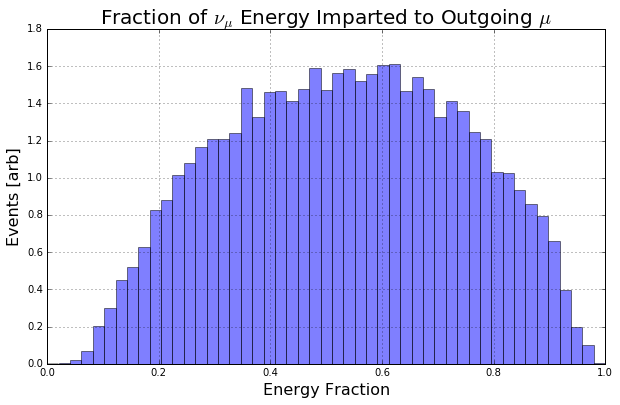

In [55]:
nu_E = df_dict['mcnu'].query('true_nu_pdg == 14 and not true_nu_CCNC')['true_nu_E']
mu_E = np.sqrt(np.square(df_dict['mcnu'].query('true_nu_pdg == 14 and not true_nu_CCNC')['true_lepton_momentum']) + np.square(0.105))

fart = plt.figure(figsize=(10,6))
blah = plt.grid(True)
blah = plt.title('Fraction of $\\nu_\mu$ Energy Imparted to Outgoing $\mu$',fontsize=20)
blah = plt.xlabel('Energy Fraction',fontsize=16)
blah = plt.ylabel('Events [arb]',fontsize=16)
blah = plt.hist(mu_E/nu_E,bins = np.linspace(0,1,50),normed=True,alpha=0.5)

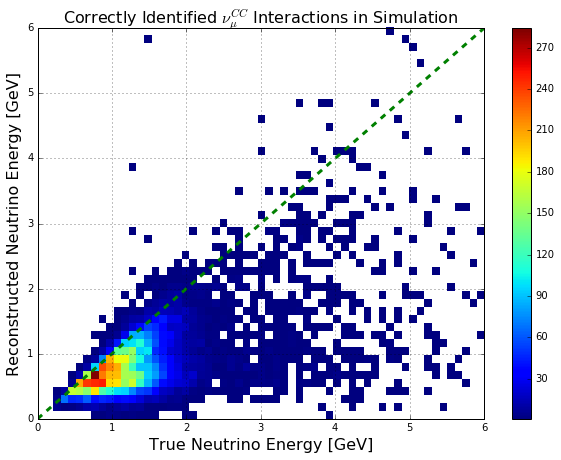

In [68]:
true_nu_E = df_dict['mcnu'].query('true_nu_pdg == 14 and not true_nu_CCNC and correct_ID')['true_nu_E']
reco_nu_E = df_dict['mcnu'].query('true_nu_pdg == 14 and not true_nu_CCNC and correct_ID')['nu_E_estimate']
blah = plt.figure(figsize=(10,7))
fart = plt.hist2d(true_nu_E,reco_nu_E,cmin=1,bins=(np.linspace(0,6,60),np.linspace(0,6,50)))
blah = plt.colorbar()
blah = plt.grid(True)
blah = plt.xlabel('True Neutrino Energy [GeV]', fontsize=16)
blah = plt.ylabel('Reconstructed Neutrino Energy [GeV]', fontsize=16)
blah = plt.title('Correctly Identified $\\nu_\mu^{CC}$ Interactions in Simulation',fontsize=16)
blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
